

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [9]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
pip install -U seaborn

In [10]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [12]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_image_count =  int(qbz95.utils.get_notebook_name().split('.')[0].split('_')[3])

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*10/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120},
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':80}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-08-09 12:14:33,191: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json


### 下载数据

开始下载数据。

In [13]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [14]:
_, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(2000, 32, 32, 3) (2000,)
(10000, 32, 32, 3) (10000,)


In [15]:
train_images[0]

array([[[0.7254902 , 0.7254902 , 0.69803922],
        [0.70196078, 0.69019608, 0.64313725],
        [0.7372549 , 0.71764706, 0.65098039],
        ...,
        [0.51372549, 0.47843137, 0.41960784],
        [0.62745098, 0.59607843, 0.55294118],
        [0.79215686, 0.77647059, 0.75686275]],

       [[0.71764706, 0.72156863, 0.70588235],
        [0.71372549, 0.70588235, 0.67058824],
        [0.76862745, 0.75294118, 0.69411765],
        ...,
        [0.5254902 , 0.48627451, 0.42745098],
        [0.62352941, 0.59215686, 0.54901961],
        [0.80392157, 0.78431373, 0.76470588]],

       [[0.71764706, 0.7254902 , 0.72156863],
        [0.71372549, 0.70980392, 0.68627451],
        [0.77647059, 0.76470588, 0.72156863],
        ...,
        [0.50980392, 0.47058824, 0.41176471],
        [0.60392157, 0.57254902, 0.52941176],
        [0.8       , 0.78431373, 0.76470588]],

       ...,

       [[0.42352941, 0.43921569, 0.44705882],
        [0.42352941, 0.43921569, 0.44705882],
        [0.40392157, 0

In [16]:
Counter(train_labels)

Counter({7: 208,
         8: 208,
         0: 197,
         6: 188,
         1: 199,
         5: 208,
         2: 188,
         4: 197,
         3: 203,
         9: 204})



### 查看数据

下面看一看实际的数据是啥样的。

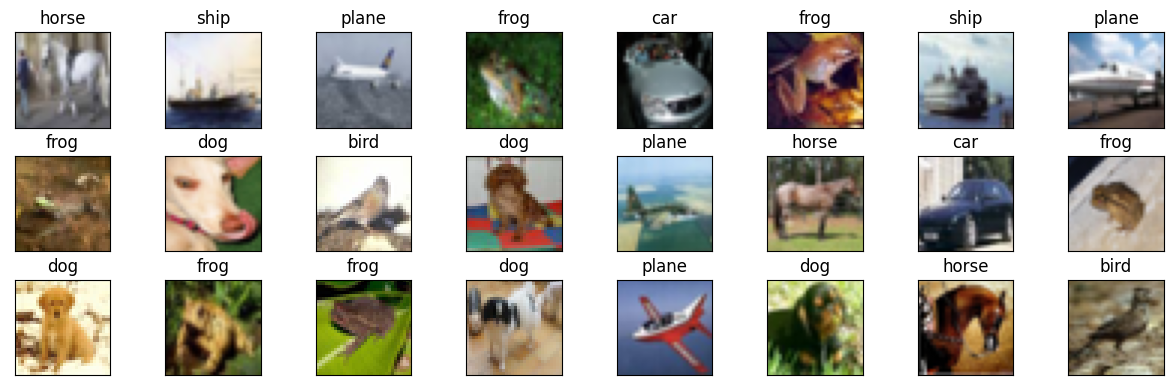

In [17]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

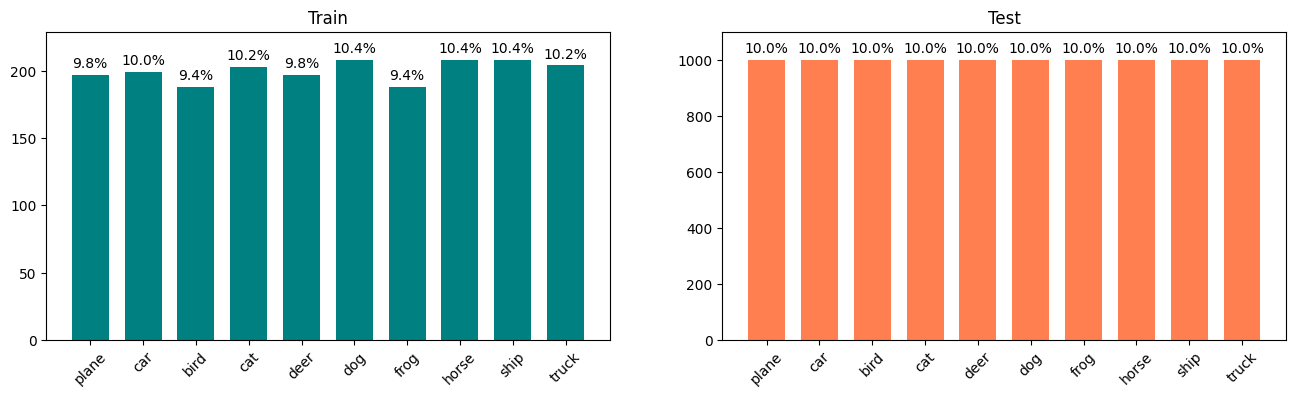

In [18]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [19]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [20]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [21]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

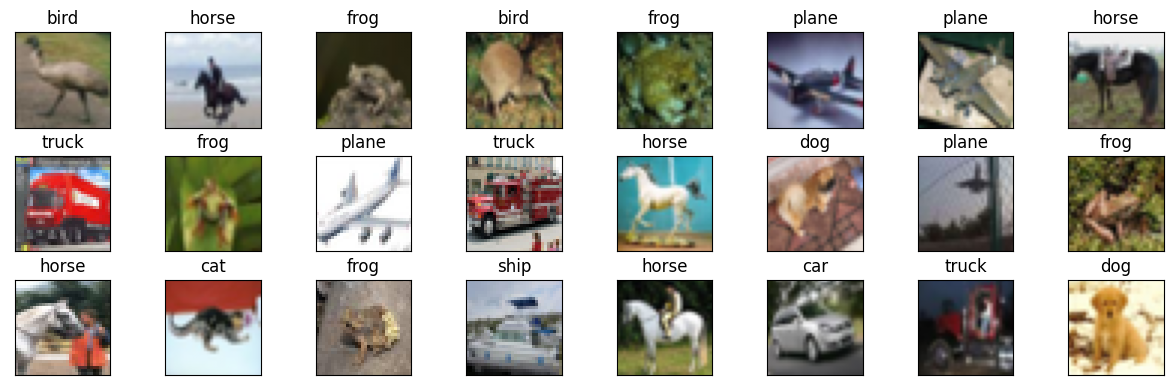

In [22]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [23]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

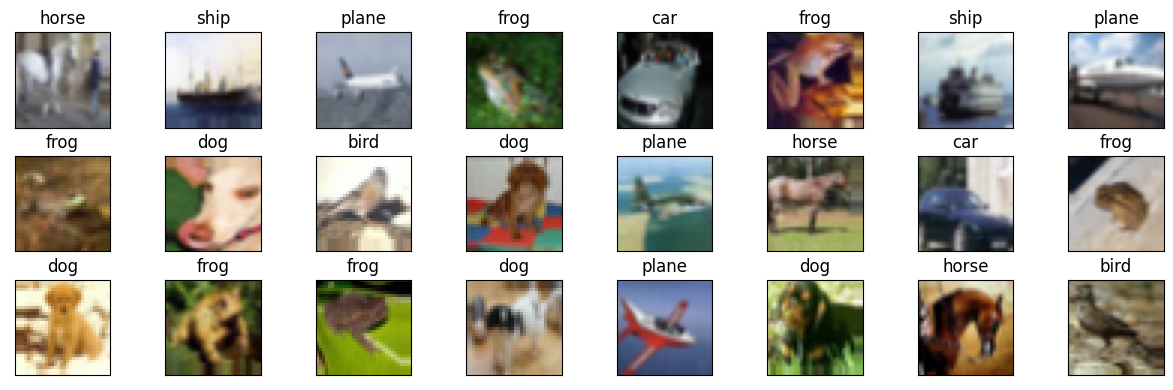

In [24]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

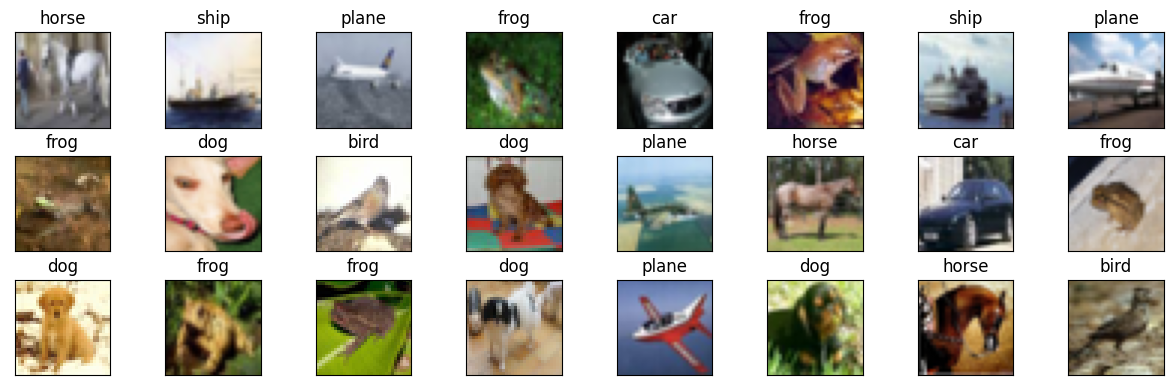

In [25]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [26]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [27]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


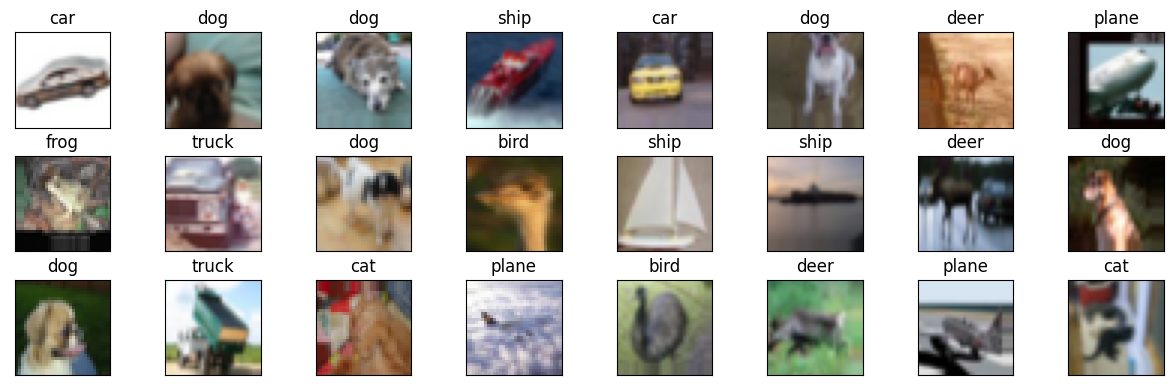

In [28]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2022-08-09 12:15:33,381: INFO: model_params.mlp1.dropout=0.1
2022-08-09 12:15:33,382: INFO: model_params.mlp1.layer_count=1
2022-08-09 12:15:33,383: INFO: model_params.mlp1.units=128
2022-08-09 12:15:33,439: INFO: learning_rate=0.001
2022-08-09 12:15:33,440: INFO: model_params.mlp1.clip_value=None
2022-08-09 12:15:33,452: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
___________________________________________________________

2022-08-09 12:15:33,471: INFO: model_params.mlp1.epochs=120
2022-08-09 12:15:33,471: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1, monitor=val_accuracy)
2022-08-09 12:15:33,472: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:15:33,473: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:15:33,474: INFO: use LearningRateScheduler()
2022-08-09 12:15:33,475: INFO: steps_per_epoch=62
2022-08-09 12:15:33,475: INFO: start training
2022-08-09 12:15:33,476: INFO: use_class_weight=False


Epoch 1/120
46/62 [=====================>........] - ETA: 0s - loss: 2.4341 - accuracy: 0.1338INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:15:35,894: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 2s 28ms/step - loss: 2.3878 - accuracy: 0.1341 - val_loss: 2.2373 - val_accuracy: 0.1590 - lr: 0.0010
Epoch 2/120
47/62 [=====================>........] - ETA: 0s - loss: 2.1897 - accuracy: 0.1875INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:15:40,039: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 4s 68ms/step - loss: 2.1926 - accuracy: 0.1789 - val_loss: 2.2000 - val_accuracy: 0.1739 - lr: 0.0010
Epoch 3/120
47/62 [=====================>........] - ETA: 0s - loss: 2.1590 - accuracy: 0.2001INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:15:45,265: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 5s 87ms/step - loss: 2.1533 - accuracy: 0.1920 - val_loss: 2.1467 - val_accuracy: 0.1891 - lr: 0.0010
Epoch 4/120
48/62 [======================>.......] - ETA: 0s - loss: 2.0942 - accuracy: 0.2096INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:15:50,605: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 5s 87ms/step - loss: 2.0948 - accuracy: 0.2067 - val_loss: 2.1019 - val_accuracy: 0.1990 - lr: 0.0010
Epoch 5/120
48/62 [======================>.......] - ETA: 0s - loss: 2.0553 - accuracy: 0.2174INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:15:52,247: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 2s 26ms/step - loss: 2.0518 - accuracy: 0.2218 - val_loss: 2.0589 - val_accuracy: 0.2247 - lr: 0.0010
Epoch 6/120
58/62 [===========================>..] - ETA: 0s - loss: 2.0171 - accuracy: 0.2338INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:15:55,436: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 3s 52ms/step - loss: 2.0141 - accuracy: 0.2349 - val_loss: 2.0238 - val_accuracy: 0.2371 - lr: 0.0010
Epoch 7/120
62/62 [==============================] - 1s 11ms/step - loss: 1.9838 - accuracy: 0.2414 - val_loss: 2.0288 - val_accuracy: 0.2264 - lr: 0.0010
Epoch 8/120
62/62 [==============================] - 1s 11ms/step - loss: 1.9635 - accuracy: 0.2646 - val_loss: 2.0234 - val_accuracy: 0.2259 - lr: 0.0010
Epoch 9/120
62/62 [==============================] - 1s 11ms/step - loss: 1.9555 - accuracy: 0.2732 - val_loss: 2.0115 - val_accuracy: 0.2356 - lr: 0.0010
Epoch 10/120
62/62 [==============================] - 1s 11ms/step - loss: 1.9479 - accuracy: 0.2656 - val_loss: 2.0152 - val_accuracy: 0.2293 - lr: 0.0010
Epoch 11/120
46/62 [=====================>........] - ETA: 0s - loss: 1.9266 - accuracy: 0.2840INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_080

2022-08-09 12:16:00,593: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 2s 40ms/step - loss: 1.9319 - accuracy: 0.2777 - val_loss: 2.0001 - val_accuracy: 0.2408 - lr: 0.0010
Epoch 12/120
62/62 [==============================] - 1s 11ms/step - loss: 1.9141 - accuracy: 0.2807 - val_loss: 2.0009 - val_accuracy: 0.2394 - lr: 0.0010
Epoch 13/120
49/62 [======================>.......] - ETA: 0s - loss: 1.9042 - accuracy: 0.2883INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:16:05,780: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 5s 74ms/step - loss: 1.9047 - accuracy: 0.2807 - val_loss: 1.9843 - val_accuracy: 0.2502 - lr: 0.0010
Epoch 14/120
45/62 [====================>.........] - ETA: 0s - loss: 1.9000 - accuracy: 0.3028INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:16:10,990: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 5s 85ms/step - loss: 1.8966 - accuracy: 0.3065 - val_loss: 1.9658 - val_accuracy: 0.2773 - lr: 0.0010
Epoch 15/120
62/62 [==============================] - 1s 11ms/step - loss: 1.8838 - accuracy: 0.3004 - val_loss: 1.9731 - val_accuracy: 0.2674 - lr: 0.0010
Epoch 16/120
62/62 [==============================] - 1s 11ms/step - loss: 1.8689 - accuracy: 0.3039 - val_loss: 1.9905 - val_accuracy: 0.2545 - lr: 0.0010
Epoch 17/120
62/62 [==============================] - 1s 13ms/step - loss: 1.8702 - accuracy: 0.2964 - val_loss: 1.9577 - val_accuracy: 0.2662 - lr: 0.0010
Epoch 18/120
62/62 [==============================] - 1s 12ms/step - loss: 1.8704 - accuracy: 0.2949 - val_loss: 1.9450 - val_accuracy: 0.2765 - lr: 0.0010
Epoch 19/120
62/62 [==============================] - 1s 11ms/step - loss: 1.8546 - accuracy: 0.3100 - val_loss: 1.9719 - val_accuracy: 0.2639 - lr: 0.0010
Epoch 20/120
62/62 [==============================] - 1s 11ms/step - loss: 1.

2022-08-09 12:16:16,861: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 2s 25ms/step - loss: 1.8219 - accuracy: 0.3276 - val_loss: 1.9332 - val_accuracy: 0.2818 - lr: 0.0010
Epoch 22/120
62/62 [==============================] - 1s 12ms/step - loss: 1.8550 - accuracy: 0.3180 - val_loss: 1.9507 - val_accuracy: 0.2742 - lr: 0.0010
Epoch 23/120
47/62 [=====================>........] - ETA: 0s - loss: 1.8116 - accuracy: 0.3285INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:16:18,938: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 22ms/step - loss: 1.8160 - accuracy: 0.3311 - val_loss: 1.9253 - val_accuracy: 0.2919 - lr: 0.0010
Epoch 24/120
46/62 [=====================>........] - ETA: 0s - loss: 1.8030 - accuracy: 0.3240INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:16:20,304: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 22ms/step - loss: 1.7979 - accuracy: 0.3266 - val_loss: 1.9202 - val_accuracy: 0.2940 - lr: 0.0010
Epoch 25/120
62/62 [==============================] - 1s 11ms/step - loss: 1.8050 - accuracy: 0.3322 - val_loss: 1.9517 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 26/120
62/62 [==============================] - 1s 11ms/step - loss: 1.8032 - accuracy: 0.3286 - val_loss: 1.9389 - val_accuracy: 0.2860 - lr: 0.0010
Epoch 27/120
62/62 [==============================] - 1s 11ms/step - loss: 1.7971 - accuracy: 0.3473 - val_loss: 1.9352 - val_accuracy: 0.2906 - lr: 0.0010
Epoch 28/120
41/62 [==================>...........] - ETA: 0s - loss: 1.7808 - accuracy: 0.3575INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:16:23,790: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 22ms/step - loss: 1.7763 - accuracy: 0.3528 - val_loss: 1.9207 - val_accuracy: 0.2941 - lr: 0.0010
Epoch 29/120
46/62 [=====================>........] - ETA: 0s - loss: 1.7864 - accuracy: 0.3451INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:16:25,074: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 21ms/step - loss: 1.7915 - accuracy: 0.3407 - val_loss: 1.9227 - val_accuracy: 0.2961 - lr: 0.0010
Epoch 30/120
62/62 [==============================] - 1s 11ms/step - loss: 1.7705 - accuracy: 0.3407 - val_loss: 1.9328 - val_accuracy: 0.2900 - lr: 0.0010
Epoch 31/120
62/62 [==============================] - 1s 11ms/step - loss: 1.7827 - accuracy: 0.3427 - val_loss: 1.9519 - val_accuracy: 0.2902 - lr: 0.0010
Epoch 32/120
45/62 [====================>.........] - ETA: 0s - loss: 1.7871 - accuracy: 0.3424INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:16:27,724: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 21ms/step - loss: 1.7741 - accuracy: 0.3438 - val_loss: 1.9258 - val_accuracy: 0.3006 - lr: 0.0010
Epoch 33/120
62/62 [==============================] - 1s 11ms/step - loss: 1.7687 - accuracy: 0.3614 - val_loss: 1.9476 - val_accuracy: 0.2904 - lr: 0.0010
Epoch 34/120
62/62 [==============================] - 1s 12ms/step - loss: 1.7608 - accuracy: 0.3523 - val_loss: 1.9442 - val_accuracy: 0.2906 - lr: 0.0010
Epoch 35/120
46/62 [=====================>........] - ETA: 0s - loss: 1.7713 - accuracy: 0.3370INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:16:30,474: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 22ms/step - loss: 1.7639 - accuracy: 0.3397 - val_loss: 1.9168 - val_accuracy: 0.3026 - lr: 0.0010
Epoch 36/120
62/62 [==============================] - 1s 11ms/step - loss: 1.7562 - accuracy: 0.3523 - val_loss: 1.9371 - val_accuracy: 0.3010 - lr: 0.0010
Epoch 37/120
62/62 [==============================] - 1s 11ms/step - loss: 1.7414 - accuracy: 0.3488 - val_loss: 1.9440 - val_accuracy: 0.2948 - lr: 0.0010
Epoch 38/120
62/62 [==============================] - 1s 12ms/step - loss: 1.7363 - accuracy: 0.3609 - val_loss: 1.9346 - val_accuracy: 0.2957 - lr: 0.0010
Epoch 39/120
62/62 [==============================] - 1s 12ms/step - loss: 1.7170 - accuracy: 0.3533 - val_loss: 1.9458 - val_accuracy: 0.2978 - lr: 0.0010
Epoch 40/120
45/62 [====================>.........] - ETA: 0s - loss: 1.7152 - accuracy: 0.3521INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_

2022-08-09 12:16:34,672: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 22ms/step - loss: 1.7054 - accuracy: 0.3569 - val_loss: 1.9392 - val_accuracy: 0.3029 - lr: 0.0010
Epoch 41/120
47/62 [=====================>........] - ETA: 0s - loss: 1.7050 - accuracy: 0.3684INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:16:35,963: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 21ms/step - loss: 1.7113 - accuracy: 0.3609 - val_loss: 1.9271 - val_accuracy: 0.3037 - lr: 0.0010
Epoch 42/120
47/62 [=====================>........] - ETA: 0s - loss: 1.7281 - accuracy: 0.3544INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:16:37,262: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 21ms/step - loss: 1.7274 - accuracy: 0.3579 - val_loss: 1.9118 - val_accuracy: 0.3082 - lr: 0.0010
Epoch 43/120
62/62 [==============================] - 1s 12ms/step - loss: 1.7074 - accuracy: 0.3700 - val_loss: 1.9322 - val_accuracy: 0.3053 - lr: 0.0010
Epoch 44/120
62/62 [==============================] - 1s 11ms/step - loss: 1.7109 - accuracy: 0.3669 - val_loss: 1.9567 - val_accuracy: 0.2993 - lr: 0.0010
Epoch 45/120
62/62 [==============================] - 1s 11ms/step - loss: 1.7015 - accuracy: 0.3589 - val_loss: 1.9617 - val_accuracy: 0.2919 - lr: 0.0010
Epoch 46/120
62/62 [==============================] - 1s 11ms/step - loss: 1.6826 - accuracy: 0.3735 - val_loss: 1.9472 - val_accuracy: 0.3022 - lr: 0.0010
Epoch 47/120
62/62 [==============================] - 1s 11ms/step - loss: 1.6753 - accuracy: 0.3725 - val_loss: 1.9470 - val_accuracy: 0.3007 - lr: 0.0010
Epoch 48/120
62/62 [==============================] - 1s 11ms/step - loss: 1.

2022-08-09 12:16:51,180: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 21ms/step - loss: 1.6044 - accuracy: 0.4088 - val_loss: 1.9219 - val_accuracy: 0.3090 - lr: 1.0000e-04
Epoch 62/120
62/62 [==============================] - 1s 11ms/step - loss: 1.6005 - accuracy: 0.4229 - val_loss: 1.9282 - val_accuracy: 0.3084 - lr: 1.0000e-04
Epoch 63/120
62/62 [==============================] - 1s 18ms/step - loss: 1.6171 - accuracy: 0.4012 - val_loss: 1.9271 - val_accuracy: 0.3059 - lr: 1.0000e-04
Epoch 64/120
62/62 [==============================] - 1s 17ms/step - loss: 1.6180 - accuracy: 0.4027 - val_loss: 1.9265 - val_accuracy: 0.3062 - lr: 1.0000e-04
Epoch 65/120
62/62 [==============================] - 1s 21ms/step - loss: 1.6141 - accuracy: 0.4083 - val_loss: 1.9253 - val_accuracy: 0.3082 - lr: 1.0000e-04
Epoch 66/120
62/62 [==============================] - 1s 12ms/step - loss: 1.6077 - accuracy: 0.4108 - val_loss: 1.9281 - val_accuracy: 0.3065 - lr: 1.0000e-04
Epoch 67/120
62/62 [==============================] -

2022-08-09 12:17:00,809: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets



Epoch 72: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
62/62 [==============================] - 1s 21ms/step - loss: 1.5954 - accuracy: 0.4279 - val_loss: 1.9305 - val_accuracy: 0.3091 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/120
44/62 [====================>.........] - ETA: 0s - loss: 1.6018 - accuracy: 0.4148INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


2022-08-09 12:17:02,118: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1/assets


62/62 [==============================] - 1s 21ms/step - loss: 1.6049 - accuracy: 0.4148 - val_loss: 1.9329 - val_accuracy: 0.3116 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/120
62/62 [==============================] - 1s 16ms/step - loss: 1.6084 - accuracy: 0.4098 - val_loss: 1.9329 - val_accuracy: 0.3104 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/120
62/62 [==============================] - 1s 13ms/step - loss: 1.5879 - accuracy: 0.4168 - val_loss: 1.9334 - val_accuracy: 0.3103 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/120
62/62 [==============================] - 1s 19ms/step - loss: 1.6023 - accuracy: 0.4189 - val_loss: 1.9331 - val_accuracy: 0.3112 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/120
62/62 [==============================] - 1s 15ms/step - loss: 1.5999 - accuracy: 0.4153 - val_loss: 

Epoch 113: early stopping


2022-08-09 12:17:32,657: INFO: finish training [elapsed time: 119.18 seconds]


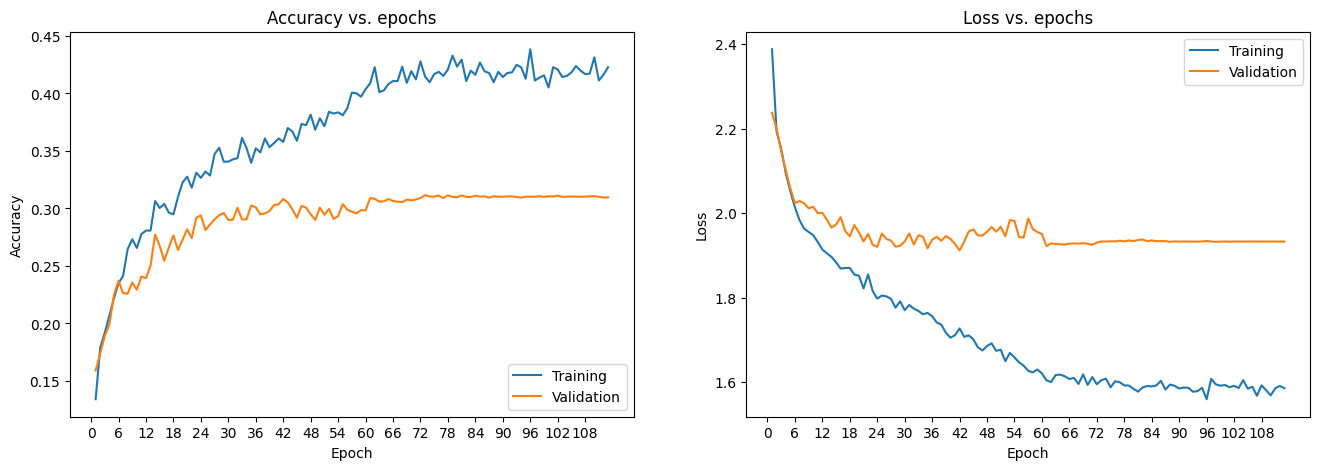

2022-08-09 12:17:33,084: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 12:17:37,289: INFO: test loss:1.9329
2022-08-09 12:17:37,290: INFO: test accuracy:0.3116
2022-08-09 12:17:37,291: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json
2022-08-09 12:17:37,293: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json
2022-08-09 12:17:37,293: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:17:37,294: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:17:37,295: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/le

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:17:38,101: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator


313/313 [==============================] - 2s 2ms/step


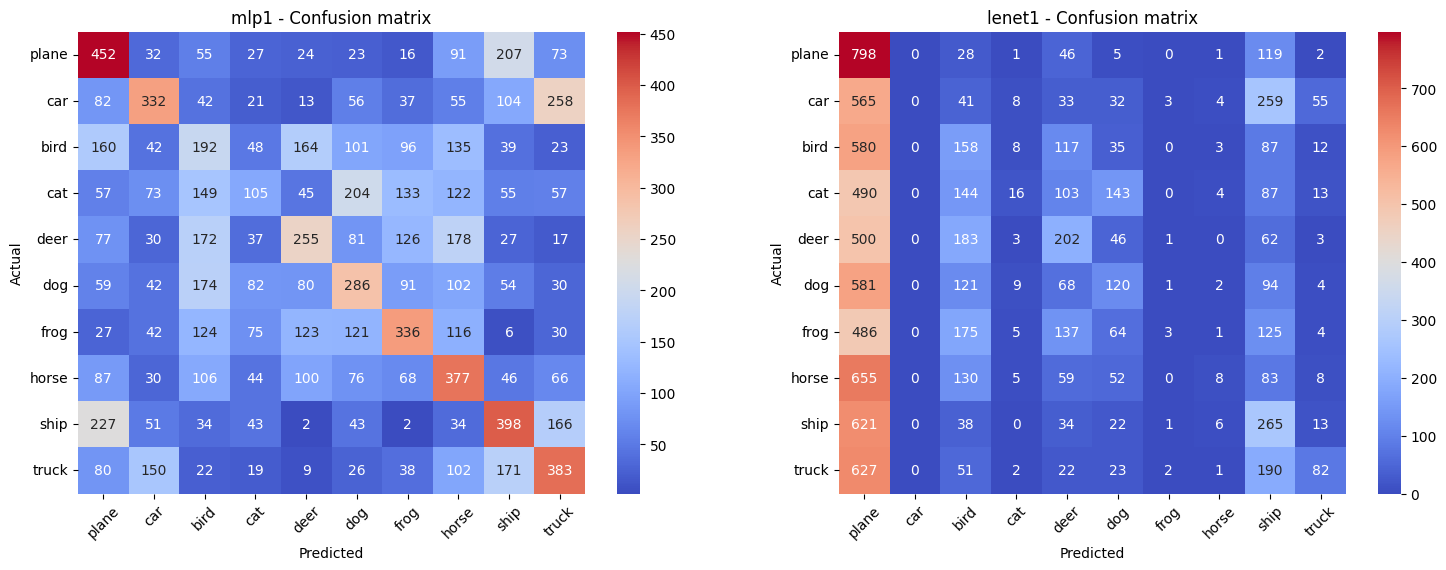

2022-08-09 12:17:43,438: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:17:44,279: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:17:44,282: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1
2022-08-09 12:17:45,230: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:17:45,232: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20
2022-08-09 12:17:49,858: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:17:49,860: INFO: loading model from /tf/eipi10/xuxiangwen.g

1/1 [==============================] - 0s 428ms/step


2022-08-09 12:17:54,265: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f98603b95e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 10ms/step


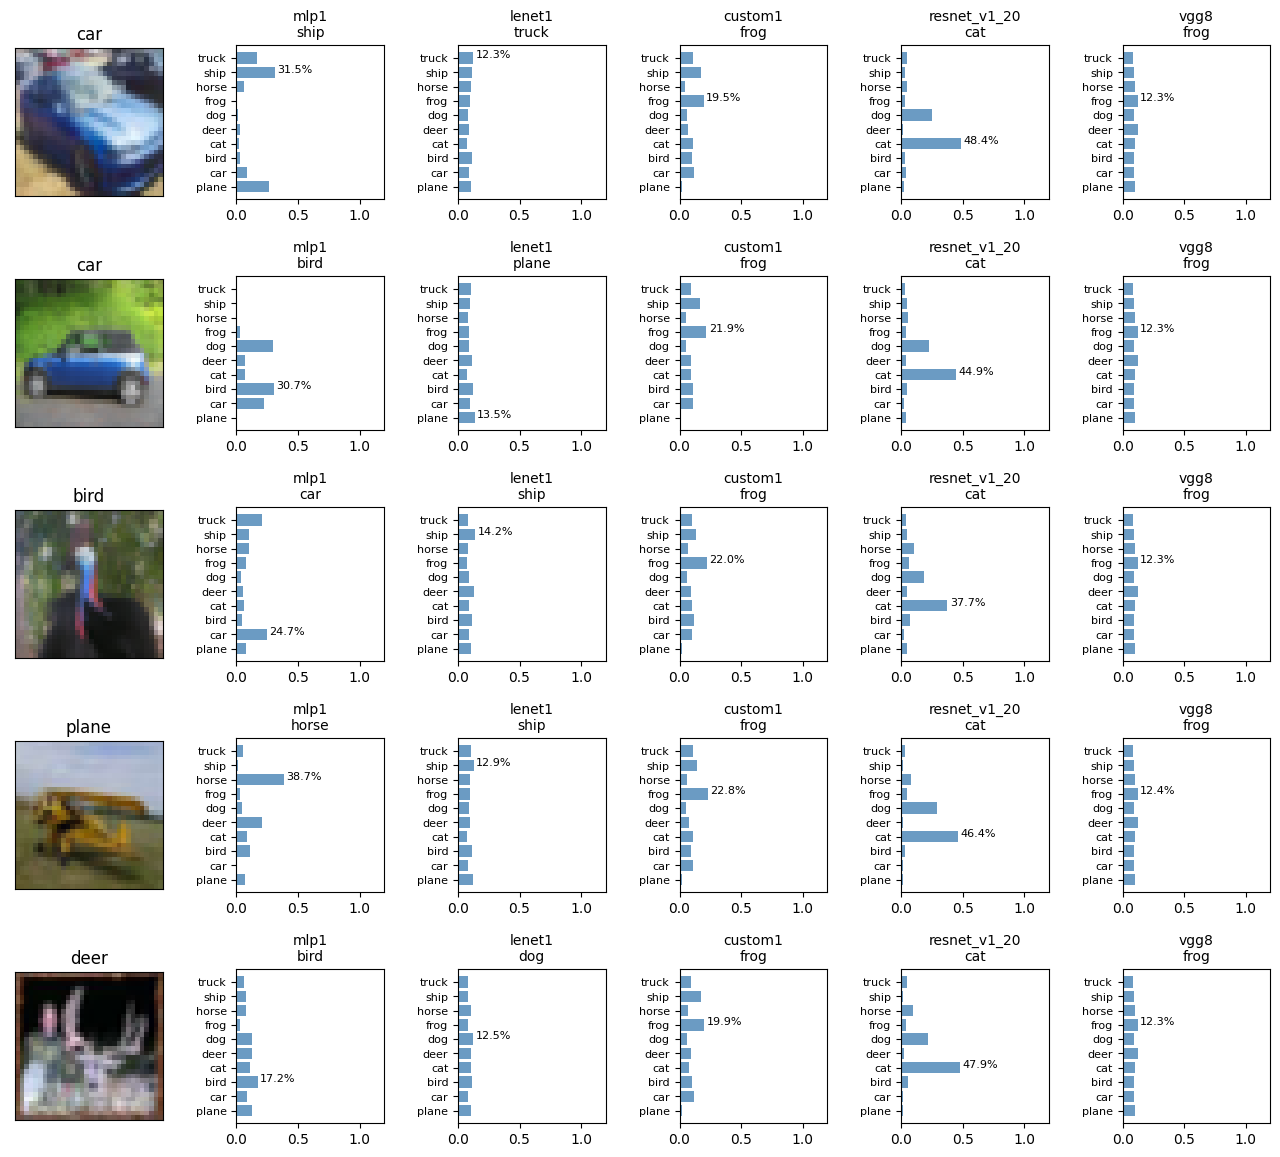

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1          mlp1  cifar10_0808_count_200.ipynb         394634       119.2   
2        lenet1  cifar10_0808_count_200.ipynb          83170         4.8   
3       custom1  cifar10_0808_count_200.ipynb          73738         4.5   
4  resnet_v1_20  cifar10_0808_count_200.ipynb         273066        17.7   
5          vgg8  cifar10_0808_count_200.ipynb        1672906         7.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:17      1.5014     1.9329          0.4745         0.3116   
2  2022-08-09 05:41      2.2456     2.2508          0.1835         0.1651   
3  2022-08-09 05:42      2.4298     2.4290          0.1280         0.1307   
4  2022-08-09 05:43      3.1658     3.1747          0.1030         0.1009   
5  2022-08-09 05:42      2.3108     2.3087          0.0940         0.1000   

   train_auc  test_auc  
1     0.8738    0.7674  
2     0.6762    0.6624  
3     0.6489    0.6352  
4     0.5820    0.5803  
5     0.5300    0.5250

In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2022-08-09 12:17:58,020: INFO: model_params.lenet1.dropout=0.2


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 12:17:58,105: INFO: learning_rate=0.001
2022-08-09 12:17:58,105: INFO: model_params.lenet1.clip_value=None
2022-08-09 12:17:58,112: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416 

2022-08-09 12:17:58,145: INFO: model_params.lenet1.epochs=120
2022-08-09 12:17:58,146: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1, monitor=val_accuracy)
2022-08-09 12:17:58,147: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:17:58,148: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:17:58,149: INFO: use LearningRateScheduler()
2022-08-09 12:17:58,149: INFO: steps_per_epoch=62
2022-08-09 12:17:58,150: INFO: start training
2022-08-09 12:17:58,151: INFO: use_class_weight=False


Epoch 1/120
53/62 [========================>.....] - ETA: 0s - loss: 2.4778 - accuracy: 0.1651

2022-08-09 12:18:01,322: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:01,930: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 4s 49ms/step - loss: 2.4348 - accuracy: 0.1714 - val_loss: 2.2501 - val_accuracy: 0.1766 - lr: 0.0010
Epoch 2/120
50/62 [=======================>......] - ETA: 0s - loss: 2.0422 - accuracy: 0.2631

2022-08-09 12:18:04,219: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:05,235: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 54ms/step - loss: 2.0366 - accuracy: 0.2651 - val_loss: 2.1214 - val_accuracy: 0.2272 - lr: 0.0010
Epoch 3/120
59/62 [===========================>..] - ETA: 0s - loss: 1.9456 - accuracy: 0.3008

2022-08-09 12:18:07,552: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:08,147: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 47ms/step - loss: 1.9383 - accuracy: 0.3054 - val_loss: 2.0275 - val_accuracy: 0.2604 - lr: 0.0010
Epoch 4/120
62/62 [==============================] - 1s 17ms/step - loss: 1.8460 - accuracy: 0.3231 - val_loss: 2.1269 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 5/120
60/62 [============================>.] - ETA: 0s - loss: 1.7448 - accuracy: 0.3786

2022-08-09 12:18:11,456: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:12,041: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 46ms/step - loss: 1.7415 - accuracy: 0.3810 - val_loss: 1.8644 - val_accuracy: 0.3316 - lr: 0.0010
Epoch 6/120
60/62 [============================>.] - ETA: 0s - loss: 1.6591 - accuracy: 0.4057

2022-08-09 12:18:14,318: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:14,928: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 47ms/step - loss: 1.6608 - accuracy: 0.4062 - val_loss: 1.8547 - val_accuracy: 0.3495 - lr: 0.0010
Epoch 7/120
53/62 [========================>.....] - ETA: 0s - loss: 1.6255 - accuracy: 0.4092

2022-08-09 12:18:17,120: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:17,696: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 45ms/step - loss: 1.6133 - accuracy: 0.4138 - val_loss: 1.6845 - val_accuracy: 0.4025 - lr: 0.0010
Epoch 8/120
62/62 [==============================] - 1s 16ms/step - loss: 1.5283 - accuracy: 0.4642 - val_loss: 1.8609 - val_accuracy: 0.3553 - lr: 0.0010
Epoch 9/120
62/62 [==============================] - 1s 16ms/step - loss: 1.4939 - accuracy: 0.4743 - val_loss: 1.7800 - val_accuracy: 0.3755 - lr: 0.0010
Epoch 10/120
62/62 [==============================] - 1s 16ms/step - loss: 1.4024 - accuracy: 0.5015 - val_loss: 2.0403 - val_accuracy: 0.3323 - lr: 0.0010
Epoch 11/120
62/62 [==============================] - 1s 16ms/step - loss: 1.3586 - accuracy: 0.5121 - val_loss: 2.0116 - val_accuracy: 0.3447 - lr: 0.0010
Epoch 12/120
62/62 [==============================] - 1s 17ms/step - loss: 1.2984 - accuracy: 0.5297 - val_loss: 2.7655 - val_accuracy: 0.2549 - lr: 0.0010
Epoch 13/120
62/62 [==============================] - 1s 17ms/step - loss: 1.24

2022-08-09 12:18:26,964: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:27,533: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 46ms/step - loss: 1.1528 - accuracy: 0.5988 - val_loss: 1.8178 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 16/120
62/62 [==============================] - 1s 16ms/step - loss: 1.0885 - accuracy: 0.5978 - val_loss: 2.5072 - val_accuracy: 0.3341 - lr: 0.0010
Epoch 17/120
62/62 [==============================] - 1s 16ms/step - loss: 1.0541 - accuracy: 0.6164 - val_loss: 2.2754 - val_accuracy: 0.3504 - lr: 0.0010
Epoch 18/120
62/62 [==============================] - 1s 16ms/step - loss: 1.0101 - accuracy: 0.6280 - val_loss: 2.6946 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 19/120
62/62 [==============================] - 1s 16ms/step - loss: 0.9722 - accuracy: 0.6462 - val_loss: 2.3029 - val_accuracy: 0.3719 - lr: 0.0010
Epoch 20/120
62/62 [==============================] - 1s 16ms/step - loss: 0.9699 - accuracy: 0.6472 - val_loss: 2.0771 - val_accuracy: 0.4006 - lr: 0.0010
Epoch 21/120
62/62 [==============================] - 1s 16ms/step - loss: 0.

2022-08-09 12:18:36,112: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:36,679: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
62/62 [==============================] - 3s 52ms/step - loss: 0.9053 - accuracy: 0.6683 - val_loss: 2.0222 - val_accuracy: 0.4288 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/120
54/62 [=========================>....] - ETA: 0s - loss: 0.8061 - accuracy: 0.7182

2022-08-09 12:18:38,874: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:39,444: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 45ms/step - loss: 0.7981 - accuracy: 0.7203 - val_loss: 1.6304 - val_accuracy: 0.4862 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/120
62/62 [==============================] - 1s 16ms/step - loss: 0.7524 - accuracy: 0.7243 - val_loss: 1.6782 - val_accuracy: 0.4783 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/120
54/62 [=========================>....] - ETA: 0s - loss: 0.7118 - accuracy: 0.7506

2022-08-09 12:18:42,641: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:43,249: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 46ms/step - loss: 0.7055 - accuracy: 0.7515 - val_loss: 1.6553 - val_accuracy: 0.4878 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/120
62/62 [==============================] - 1s 16ms/step - loss: 0.7154 - accuracy: 0.7445 - val_loss: 1.7526 - val_accuracy: 0.4646 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/120
62/62 [==============================] - 1s 16ms/step - loss: 0.6982 - accuracy: 0.7525 - val_loss: 1.7349 - val_accuracy: 0.4752 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/120
62/62 [==============================] - 1s 16ms/step - loss: 0.7046 - accuracy: 0.7440 - val_loss: 1.6691 - val_accuracy: 0.4823 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/120
62/62 [==============================] - 1s 21ms/step - loss: 0.6710 - accuracy: 0.7601 - val_loss: 

2022-08-09 12:18:58,780: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:18:59,408: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
62/62 [==============================] - 3s 54ms/step - loss: 0.5989 - accuracy: 0.7908 - val_loss: 1.7948 - val_accuracy: 0.4918 - lr: 1.0000e-04
Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/120
62/62 [==============================] - 1s 16ms/step - loss: 0.5470 - accuracy: 0.7984 - val_loss: 1.7393 - val_accuracy: 0.4860 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/120
62/62 [==============================] - 1s 16ms/step - loss: 0.5336 - accuracy: 0.8145 - val_loss: 1.7935 - val_accuracy: 0.4823 - lr: 1.0000e-04
Epoch 00041: Still keep learning rate 0.0001 instead of 0.001
Epoch 41/120
62/62 [==============================] - 1s 16ms/step - loss: 0.5167 - accuracy: 0.8115 - val_loss: 1.7747 - val_accuracy: 0.4784 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/120
62/62 [==========================

2022-08-09 12:19:15,405: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:19:15,954: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets



Epoch 53: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
62/62 [==============================] - 3s 44ms/step - loss: 0.4791 - accuracy: 0.8276 - val_loss: 1.7902 - val_accuracy: 0.4922 - lr: 3.1623e-05
Epoch 00054: LearningRateScheduler reducing learning rate to 0.001 from 3.16e-05.
Epoch 54/120
62/62 [==============================] - 1s 16ms/step - loss: 0.6081 - accuracy: 0.7863 - val_loss: 1.8133 - val_accuracy: 0.4837 - lr: 0.0010
Epoch 55/120
62/62 [==============================] - 1s 16ms/step - loss: 0.6210 - accuracy: 0.7732 - val_loss: 2.0001 - val_accuracy: 0.4304 - lr: 0.0010
Epoch 56/120
62/62 [==============================] - 1s 16ms/step - loss: 0.5948 - accuracy: 0.7908 - val_loss: 3.4891 - val_accuracy: 0.3483 - lr: 0.0010
Epoch 57/120
62/62 [==============================] - 1s 16ms/step - loss: 0.5908 - accuracy: 0.7959 - val_loss: 2.6016 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 58/120
62/62 [==============================] - 1s 16ms/step -

2022-08-09 12:19:29,908: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:19:30,883: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 51ms/step - loss: 0.3971 - accuracy: 0.8569 - val_loss: 1.9192 - val_accuracy: 0.4961 - lr: 1.0000e-04
Epoch 67/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3843 - accuracy: 0.8684 - val_loss: 1.8925 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 68/120
53/62 [========================>.....] - ETA: 0s - loss: 0.4080 - accuracy: 0.8532
Epoch 68: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
62/62 [==============================] - 1s 16ms/step - loss: 0.4110 - accuracy: 0.8503 - val_loss: 1.8815 - val_accuracy: 0.4893 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3796 - accuracy: 0.8684 - val_loss: 1.8938 - val_accuracy: 0.4934 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3898 

2022-08-09 12:19:41,035: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:19:41,593: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 45ms/step - loss: 0.3773 - accuracy: 0.8664 - val_loss: 1.9075 - val_accuracy: 0.4967 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3389 - accuracy: 0.8836 - val_loss: 1.9078 - val_accuracy: 0.4928 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3521 - accuracy: 0.8720 - val_loss: 1.9216 - val_accuracy: 0.4955 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3451 - accuracy: 0.8866 - val_loss: 1.9188 - val_accuracy: 0.4946 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/120
55/62 [=========================>....] - ETA: 0s - loss: 0.3649 - accuracy: 0.8767

2022-08-09 12:19:46,688: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:19:47,246: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 44ms/step - loss: 0.3598 - accuracy: 0.8800 - val_loss: 1.9143 - val_accuracy: 0.4971 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3566 - accuracy: 0.8800 - val_loss: 1.9175 - val_accuracy: 0.4955 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3464 - accuracy: 0.8846 - val_loss: 1.9166 - val_accuracy: 0.4938 - lr: 3.1623e-05
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 82/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3534 - accuracy: 0.8770 - val_loss: 1.9348 - val_accuracy: 0.4964 - lr: 3.1623e-05
Epoch 00083: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 83/120
55/62 [=========================>....] - ETA: 0s - loss: 0.3880 - accuracy: 0.8648
Epoch 83: ReduceL

2022-08-09 12:19:59,251: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:19:59,806: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 44ms/step - loss: 0.3542 - accuracy: 0.8760 - val_loss: 1.9210 - val_accuracy: 0.4972 - lr: 1.0000e-05
Epoch 91/120
52/62 [========================>.....] - ETA: 0s - loss: 0.3520 - accuracy: 0.8768

2022-08-09 12:20:01,995: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:20:02,549: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 45ms/step - loss: 0.3591 - accuracy: 0.8755 - val_loss: 1.9186 - val_accuracy: 0.4973 - lr: 1.0000e-05
Epoch 92/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3711 - accuracy: 0.8740 - val_loss: 1.9155 - val_accuracy: 0.4965 - lr: 1.0000e-05
Epoch 93/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3513 - accuracy: 0.8725 - val_loss: 1.9225 - val_accuracy: 0.4968 - lr: 1.0000e-05
Epoch 94/120
51/62 [=======================>......] - ETA: 0s - loss: 0.3199 - accuracy: 0.8891

2022-08-09 12:20:06,707: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:20:07,267: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 44ms/step - loss: 0.3252 - accuracy: 0.8906 - val_loss: 1.9260 - val_accuracy: 0.4984 - lr: 1.0000e-05
Epoch 95/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3599 - accuracy: 0.8710 - val_loss: 1.9227 - val_accuracy: 0.4978 - lr: 1.0000e-05
Epoch 96/120
53/62 [========================>.....] - ETA: 0s - loss: 0.3835 - accuracy: 0.8650

2022-08-09 12:20:10,879: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


2022-08-09 12:20:11,443: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1/assets


62/62 [==============================] - 3s 52ms/step - loss: 0.3762 - accuracy: 0.8659 - val_loss: 1.9174 - val_accuracy: 0.4985 - lr: 1.0000e-05
Epoch 97/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3609 - accuracy: 0.8664 - val_loss: 1.9244 - val_accuracy: 0.4960 - lr: 1.0000e-05
Epoch 98/120
56/62 [==========================>...] - ETA: 0s - loss: 0.3666 - accuracy: 0.8756
Epoch 98: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.
62/62 [==============================] - 1s 16ms/step - loss: 0.3617 - accuracy: 0.8755 - val_loss: 1.9223 - val_accuracy: 0.4960 - lr: 3.1623e-06
Epoch 00099: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 99/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3813 - accuracy: 0.8715 - val_loss: 1.9210 - val_accuracy: 0.4960 - lr: 3.1623e-06
Epoch 00100: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 100/120
62/62 [==============================] - 1s 16ms/step - loss: 0.3518 - a

2022-08-09 12:20:35,739: INFO: finish training [elapsed time: 157.59 seconds]


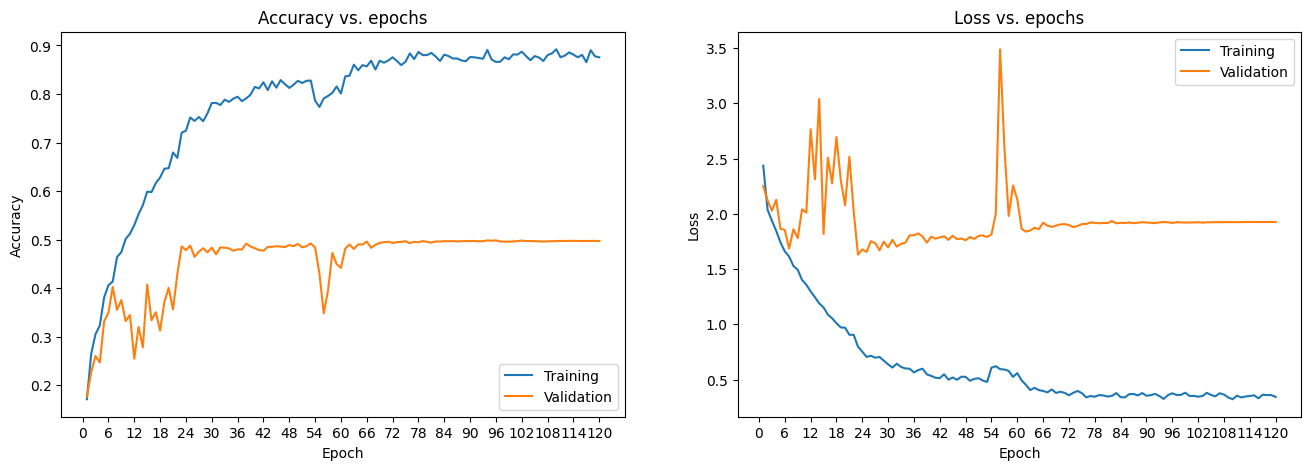

2022-08-09 12:20:36,173: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 12:20:41,090: INFO: test loss:1.9174
2022-08-09 12:20:41,091: INFO: test accuracy:0.4985
2022-08-09 12:20:41,092: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json
2022-08-09 12:20:41,094: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json
2022-08-09 12:20:41,095: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:20:41,096: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:20:41,097: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/ml

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:20:41,375: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator


313/313 [==============================] - 1s 2ms/step


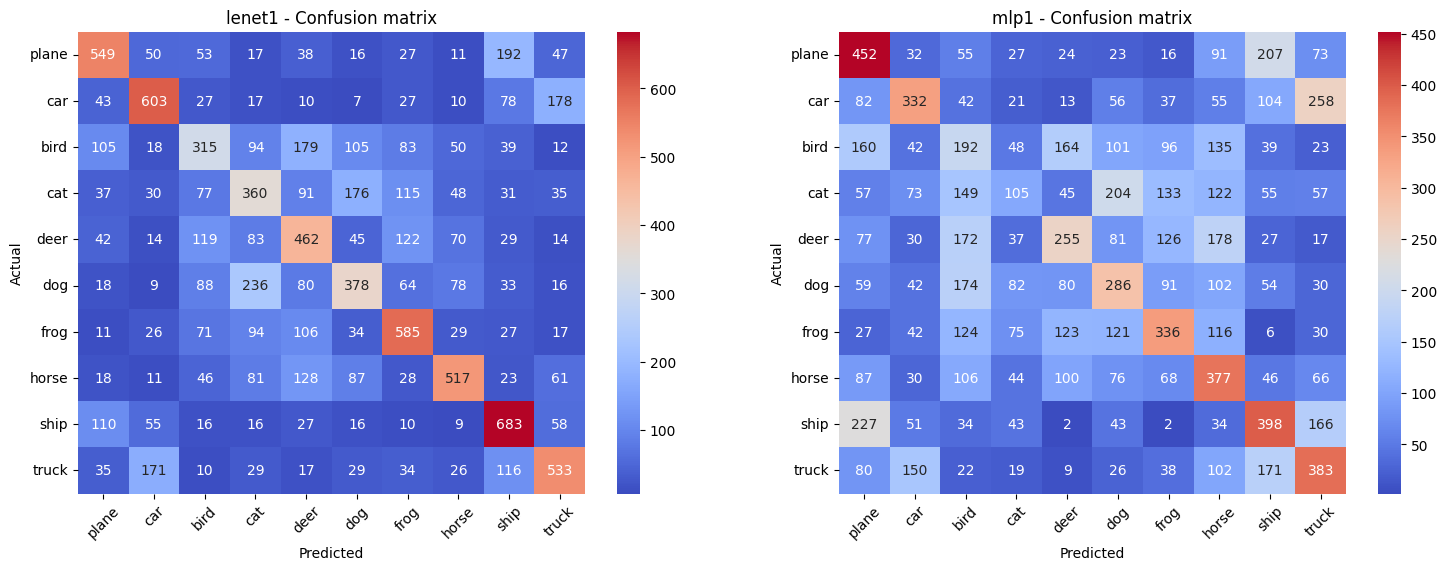

2022-08-09 12:20:45,639: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:20:45,909: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:20:45,911: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1
2022-08-09 12:20:46,787: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:20:46,789: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20
2022-08-09 12:20:51,486: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:20:51,491: INFO: loading model from /tf/eipi10/xuxiangwen.g

1/1 [==============================] - 0s 387ms/step


2022-08-09 12:20:55,455: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f990407d700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 10ms/step


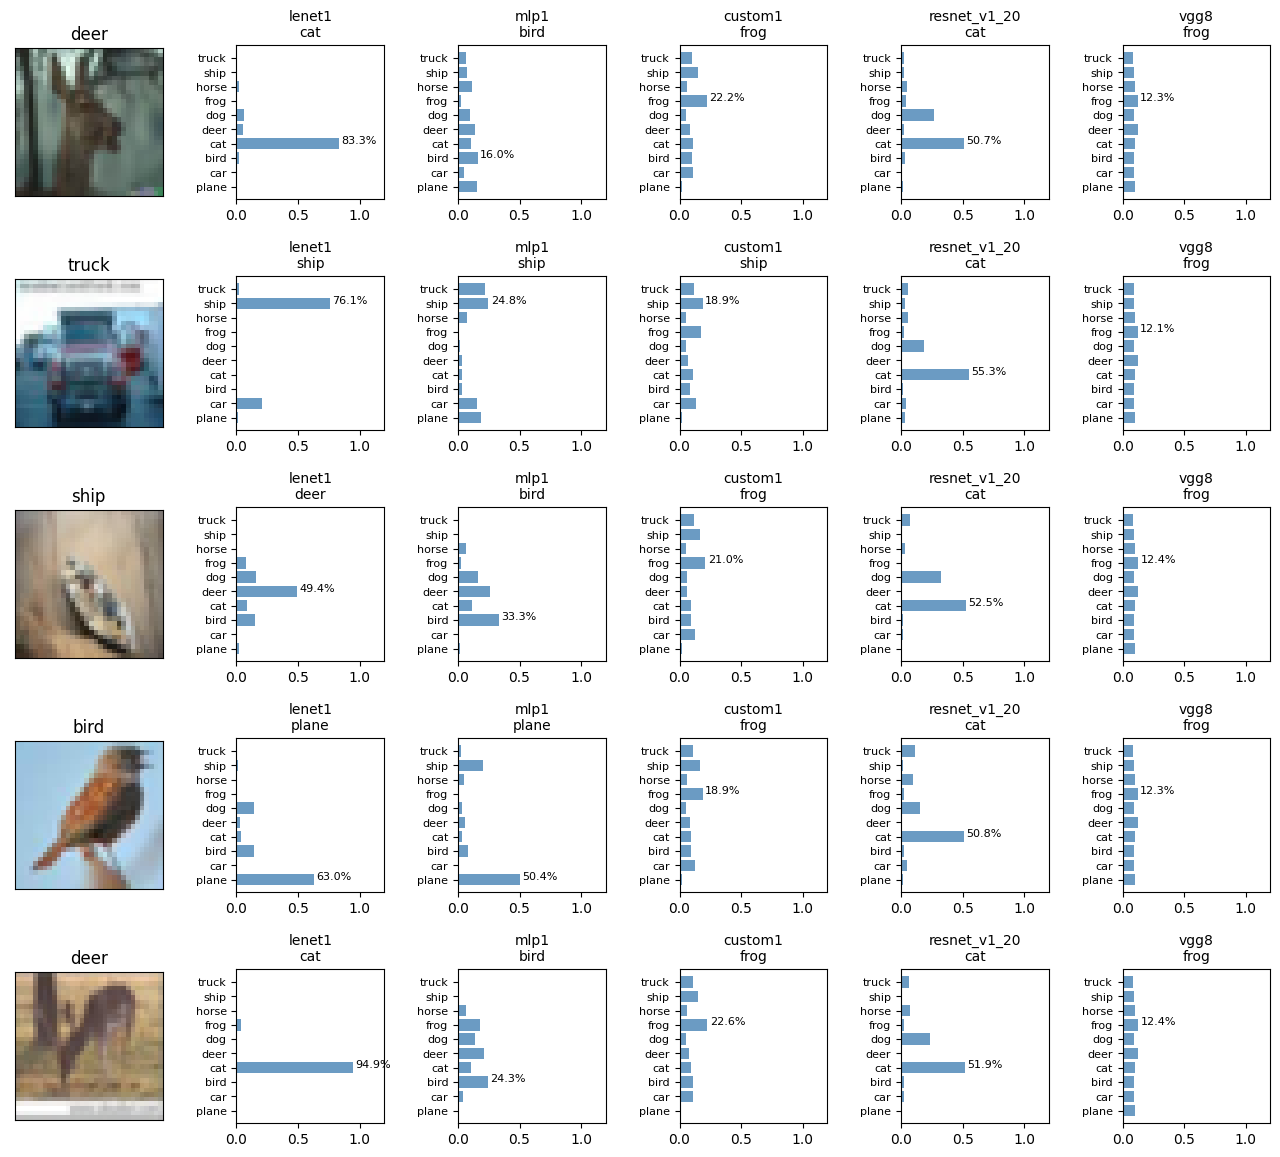

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1        lenet1  cifar10_0808_count_200.ipynb          83170       157.6   
2          mlp1  cifar10_0808_count_200.ipynb         394634       119.2   
3       custom1  cifar10_0808_count_200.ipynb          73738         4.5   
4  resnet_v1_20  cifar10_0808_count_200.ipynb         273066        17.7   
5          vgg8  cifar10_0808_count_200.ipynb        1672906         7.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:20      0.0952     1.9174          0.9845         0.4985   
2  2022-08-09 12:17      1.5014     1.9329          0.4745         0.3116   
3  2022-08-09 05:42      2.4298     2.4290          0.1280         0.1307   
4  2022-08-09 05:43      3.1658     3.1747          0.1030         0.1009   
5  2022-08-09 05:42      2.3108     2.3087          0.0940         0.1000   

   train_auc  test_auc  
1     0.9992    0.8764  
2     0.8738    0.7674  
3     0.6489    0.6352  
4     0.5820    0.5803  
5     0.5300    0.5250

In [30]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2022-08-09 12:20:59,676: INFO: model_params.custom1.dropout=0.2


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 12:20:59,776: INFO: learning_rate=0.001
2022-08-09 12:20:59,777: INFO: model_params.custom1.clip_value=None
2022-08-09 12:20:59,783: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        1849

2022-08-09 12:20:59,816: INFO: model_params.custom1.epochs=120
2022-08-09 12:20:59,817: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1, monitor=val_accuracy)
2022-08-09 12:20:59,817: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:20:59,818: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:20:59,819: INFO: use LearningRateScheduler()
2022-08-09 12:20:59,819: INFO: steps_per_epoch=62
2022-08-09 12:20:59,820: INFO: start training
2022-08-09 12:20:59,820: INFO: use_class_weight=False


Epoch 1/120
61/62 [============================>.] - ETA: 0s - loss: 2.4134 - accuracy: 0.2152

2022-08-09 12:21:03,192: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:03,820: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 4s 53ms/step - loss: 2.4082 - accuracy: 0.2147 - val_loss: 2.5467 - val_accuracy: 0.1028 - lr: 0.0010
Epoch 2/120
61/62 [============================>.] - ETA: 0s - loss: 1.9588 - accuracy: 0.2843

2022-08-09 12:21:06,226: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:06,855: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 50ms/step - loss: 1.9551 - accuracy: 0.2843 - val_loss: 2.9974 - val_accuracy: 0.1213 - lr: 0.0010
Epoch 3/120
58/62 [===========================>..] - ETA: 0s - loss: 1.8307 - accuracy: 0.3206

2022-08-09 12:21:09,289: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:09,917: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 50ms/step - loss: 1.8199 - accuracy: 0.3251 - val_loss: 3.2745 - val_accuracy: 0.1251 - lr: 0.0010
Epoch 4/120
61/62 [============================>.] - ETA: 0s - loss: 1.6987 - accuracy: 0.3858

2022-08-09 12:21:12,318: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:12,941: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 49ms/step - loss: 1.6978 - accuracy: 0.3841 - val_loss: 3.2250 - val_accuracy: 0.1428 - lr: 0.0010
Epoch 5/120
61/62 [============================>.] - ETA: 0s - loss: 1.6244 - accuracy: 0.3996

2022-08-09 12:21:15,864: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:16,499: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 4s 58ms/step - loss: 1.6252 - accuracy: 0.3967 - val_loss: 3.2498 - val_accuracy: 0.1480 - lr: 0.0010
Epoch 6/120
61/62 [============================>.] - ETA: 0s - loss: 1.5546 - accuracy: 0.4447

2022-08-09 12:21:18,918: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:19,547: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 50ms/step - loss: 1.5547 - accuracy: 0.4451 - val_loss: 2.4378 - val_accuracy: 0.1872 - lr: 0.0010
Epoch 7/120
61/62 [============================>.] - ETA: 0s - loss: 1.4576 - accuracy: 0.4636

2022-08-09 12:21:21,963: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:22,594: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 50ms/step - loss: 1.4609 - accuracy: 0.4607 - val_loss: 2.1757 - val_accuracy: 0.2727 - lr: 0.0010
Epoch 8/120
61/62 [============================>.] - ETA: 0s - loss: 1.3886 - accuracy: 0.4928

2022-08-09 12:21:24,998: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:25,627: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 50ms/step - loss: 1.3924 - accuracy: 0.4904 - val_loss: 2.2432 - val_accuracy: 0.2803 - lr: 0.0010
Epoch 9/120
61/62 [============================>.] - ETA: 0s - loss: 1.3613 - accuracy: 0.4913

2022-08-09 12:21:28,046: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:29,070: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 56ms/step - loss: 1.3669 - accuracy: 0.4904 - val_loss: 1.6751 - val_accuracy: 0.3997 - lr: 0.0010
Epoch 10/120
61/62 [============================>.] - ETA: 0s - loss: 1.3056 - accuracy: 0.5287

2022-08-09 12:21:31,505: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:32,137: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 50ms/step - loss: 1.3078 - accuracy: 0.5267 - val_loss: 1.7078 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 11/120
62/62 [==============================] - 1s 18ms/step - loss: 1.2693 - accuracy: 0.5318 - val_loss: 1.8732 - val_accuracy: 0.4095 - lr: 0.0010
Epoch 12/120
60/62 [============================>.] - ETA: 0s - loss: 1.2050 - accuracy: 0.5651

2022-08-09 12:21:35,664: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:36,282: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 50ms/step - loss: 1.2045 - accuracy: 0.5650 - val_loss: 1.5350 - val_accuracy: 0.4764 - lr: 0.0010
Epoch 13/120
62/62 [==============================] - 1s 18ms/step - loss: 1.1251 - accuracy: 0.5943 - val_loss: 2.2738 - val_accuracy: 0.3354 - lr: 0.0010
Epoch 14/120
62/62 [==============================] - 1s 18ms/step - loss: 1.1018 - accuracy: 0.6013 - val_loss: 1.6149 - val_accuracy: 0.4528 - lr: 0.0010
Epoch 15/120
62/62 [==============================] - 1s 18ms/step - loss: 1.0785 - accuracy: 0.6210 - val_loss: 1.6260 - val_accuracy: 0.4630 - lr: 0.0010
Epoch 16/120
62/62 [==============================] - 1s 18ms/step - loss: 1.0152 - accuracy: 0.6346 - val_loss: 2.0394 - val_accuracy: 0.3766 - lr: 0.0010
Epoch 17/120
56/62 [==========================>...] - ETA: 0s - loss: 0.9615 - accuracy: 0.6507

2022-08-09 12:21:43,196: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:43,828: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 51ms/step - loss: 0.9582 - accuracy: 0.6497 - val_loss: 1.5564 - val_accuracy: 0.4791 - lr: 0.0010
Epoch 18/120
62/62 [==============================] - 1s 18ms/step - loss: 0.9562 - accuracy: 0.6628 - val_loss: 1.8959 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 19/120
62/62 [==============================] - 1s 18ms/step - loss: 0.9204 - accuracy: 0.6749 - val_loss: 1.6791 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 20/120
59/62 [===========================>..] - ETA: 0s - loss: 0.8840 - accuracy: 0.6706

2022-08-09 12:21:48,513: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:49,180: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 52ms/step - loss: 0.8789 - accuracy: 0.6714 - val_loss: 1.6402 - val_accuracy: 0.4798 - lr: 0.0010
Epoch 21/120
62/62 [==============================] - 1s 18ms/step - loss: 0.8541 - accuracy: 0.6855 - val_loss: 1.6140 - val_accuracy: 0.4604 - lr: 0.0010
Epoch 22/120
62/62 [==============================] - 1s 18ms/step - loss: 0.8025 - accuracy: 0.7036 - val_loss: 1.6658 - val_accuracy: 0.4717 - lr: 0.0010
Epoch 23/120
62/62 [==============================] - 1s 18ms/step - loss: 0.8337 - accuracy: 0.6946 - val_loss: 2.1397 - val_accuracy: 0.4016 - lr: 0.0010
Epoch 24/120
57/62 [==========================>...] - ETA: 0s - loss: 0.7887 - accuracy: 0.7193

2022-08-09 12:21:55,036: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:21:56,159: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 4s 60ms/step - loss: 0.7802 - accuracy: 0.7228 - val_loss: 1.5509 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 25/120
62/62 [==============================] - 1s 20ms/step - loss: 0.7212 - accuracy: 0.7394 - val_loss: 1.6682 - val_accuracy: 0.4619 - lr: 0.0010
Epoch 26/120
59/62 [===========================>..] - ETA: 0s - loss: 0.6976 - accuracy: 0.7394

2022-08-09 12:21:59,860: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:22:00,518: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 51ms/step - loss: 0.6919 - accuracy: 0.7424 - val_loss: 1.5379 - val_accuracy: 0.5133 - lr: 0.0010
Epoch 27/120
60/62 [============================>.] - ETA: 0s - loss: 0.6710 - accuracy: 0.7630
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
62/62 [==============================] - 1s 18ms/step - loss: 0.6722 - accuracy: 0.7616 - val_loss: 1.6426 - val_accuracy: 0.5095 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/120
59/62 [===========================>..] - ETA: 0s - loss: 0.5801 - accuracy: 0.7929

2022-08-09 12:22:04,144: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:22:04,809: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 52ms/step - loss: 0.5823 - accuracy: 0.7918 - val_loss: 1.6150 - val_accuracy: 0.5140 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/120
60/62 [============================>.] - ETA: 0s - loss: 0.5224 - accuracy: 0.8193

2022-08-09 12:22:07,371: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:22:08,037: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 53ms/step - loss: 0.5182 - accuracy: 0.8216 - val_loss: 1.4983 - val_accuracy: 0.5235 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/120
61/62 [============================>.] - ETA: 0s - loss: 0.4971 - accuracy: 0.8233

2022-08-09 12:22:10,606: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:22:11,269: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 53ms/step - loss: 0.4964 - accuracy: 0.8236 - val_loss: 1.4994 - val_accuracy: 0.5329 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/120
62/62 [==============================] - 1s 18ms/step - loss: 0.5162 - accuracy: 0.8216 - val_loss: 1.6654 - val_accuracy: 0.5155 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/120
62/62 [==============================] - 1s 18ms/step - loss: 0.4939 - accuracy: 0.8196 - val_loss: 1.6643 - val_accuracy: 0.5223 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/120
62/62 [==============================] - 1s 18ms/step - loss: 0.4960 - accuracy: 0.8241 - val_loss: 1.5931 - val_accuracy: 0.5141 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/120
62/62 [==============================] - 1s 18ms/step - loss: 0.4478 - accuracy: 0.8432 - val_loss: 

2022-08-09 12:22:24,188: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:22:24,904: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 4s 62ms/step - loss: 0.4067 - accuracy: 0.8513 - val_loss: 1.5905 - val_accuracy: 0.5397 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/120
62/62 [==============================] - 1s 18ms/step - loss: 0.3770 - accuracy: 0.8659 - val_loss: 1.5992 - val_accuracy: 0.5351 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/120
62/62 [==============================] - 1s 18ms/step - loss: 0.3938 - accuracy: 0.8679 - val_loss: 1.5987 - val_accuracy: 0.5278 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/120
62/62 [==============================] - 1s 18ms/step - loss: 0.3903 - accuracy: 0.8614 - val_loss: 1.7210 - val_accuracy: 0.5231 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/120
56/62 [==========================>...] - ETA: 0s - loss: 0.4120 - accuracy: 0.8532
Epoch 44: ReduceL

2022-08-09 12:22:34,117: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:22:34,942: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 56ms/step - loss: 0.3468 - accuracy: 0.8795 - val_loss: 1.5904 - val_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/120
62/62 [==============================] - 1s 18ms/step - loss: 0.3247 - accuracy: 0.8896 - val_loss: 1.6702 - val_accuracy: 0.5374 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/120
62/62 [==============================] - 1s 18ms/step - loss: 0.3320 - accuracy: 0.8841 - val_loss: 1.7043 - val_accuracy: 0.5418 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/120
62/62 [==============================] - 1s 18ms/step - loss: 0.3469 - accuracy: 0.8740 - val_loss: 1.7112 - val_accuracy: 0.5370 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/120
62/62 [==============================] - 1s 18ms/step - loss: 0.2933 - accuracy: 0.9037 - val_loss: 1.7353 - val

2022-08-09 12:22:49,778: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:22:50,488: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets



Epoch 59: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
62/62 [==============================] - 3s 56ms/step - loss: 0.3090 - accuracy: 0.8947 - val_loss: 1.6645 - val_accuracy: 0.5486 - lr: 3.1623e-05
Epoch 00060: LearningRateScheduler reducing learning rate to 0.001 from 3.16e-05.
Epoch 60/120
62/62 [==============================] - 1s 18ms/step - loss: 0.4192 - accuracy: 0.8543 - val_loss: 2.4536 - val_accuracy: 0.4192 - lr: 0.0010
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
Epoch 61/120
62/62 [==============================] - 1s 19ms/step - loss: 0.3890 - accuracy: 0.8679 - val_loss: 1.7114 - val_accuracy: 0.5445 - lr: 1.0000e-04
Epoch 62/120
62/62 [==============================] - 1s 18ms/step - loss: 0.3429 - accuracy: 0.8836 - val_loss: 1.7251 - val_accuracy: 0.5432 - lr: 1.0000e-04
Epoch 63/120
62/62 [==============================] - 1s 19ms/step - loss: 0.3303 - accuracy: 0.8851 - val_loss: 1.7005 - val_accuracy: 

2022-08-09 12:23:09,921: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:23:10,625: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 55ms/step - loss: 0.2722 - accuracy: 0.9078 - val_loss: 1.7137 - val_accuracy: 0.5493 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/120
62/62 [==============================] - 1s 19ms/step - loss: 0.2608 - accuracy: 0.9153 - val_loss: 1.7175 - val_accuracy: 0.5486 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/120
59/62 [===========================>..] - ETA: 0s - loss: 0.2701 - accuracy: 0.9105

2022-08-09 12:23:14,574: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:23:15,316: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 3s 57ms/step - loss: 0.2724 - accuracy: 0.9093 - val_loss: 1.7123 - val_accuracy: 0.5522 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/120
62/62 [==============================] - 1s 18ms/step - loss: 0.2702 - accuracy: 0.9062 - val_loss: 1.7568 - val_accuracy: 0.5458 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/120
62/62 [==============================] - 1s 19ms/step - loss: 0.2762 - accuracy: 0.8942 - val_loss: 1.7489 - val_accuracy: 0.5487 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/120
62/62 [==============================] - 1s 18ms/step - loss: 0.2562 - accuracy: 0.9123 - val_loss: 1.7577 - val_accuracy: 0.5464 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
62/62 [==============================] - 1s 18ms/step - loss: 0.2605 - accuracy: 0.9138 - val_loss: 

2022-08-09 12:23:27,424: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


2022-08-09 12:23:28,123: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1/assets


62/62 [==============================] - 4s 62ms/step - loss: 0.2530 - accuracy: 0.9194 - val_loss: 1.6948 - val_accuracy: 0.5523 - lr: 3.1623e-05
Epoch 00087: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 87/120
62/62 [==============================] - 1s 18ms/step - loss: 0.2488 - accuracy: 0.9143 - val_loss: 1.7207 - val_accuracy: 0.5507 - lr: 3.1623e-05
Epoch 00088: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 88/120
62/62 [==============================] - 1s 18ms/step - loss: 0.2441 - accuracy: 0.9178 - val_loss: 1.7540 - val_accuracy: 0.5486 - lr: 3.1623e-05
Epoch 00089: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 89/120
61/62 [============================>.] - ETA: 0s - loss: 0.2765 - accuracy: 0.9057
Epoch 89: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
62/62 [==============================] - 1s 18ms/step - loss: 0.2763 - accuracy: 0.9057 - val_loss: 1.7474 - val_accuracy: 0.5485 - lr: 1.0000e-05
Epoch 00090: Still

2022-08-09 12:24:06,705: INFO: finish training [elapsed time: 186.89 seconds]


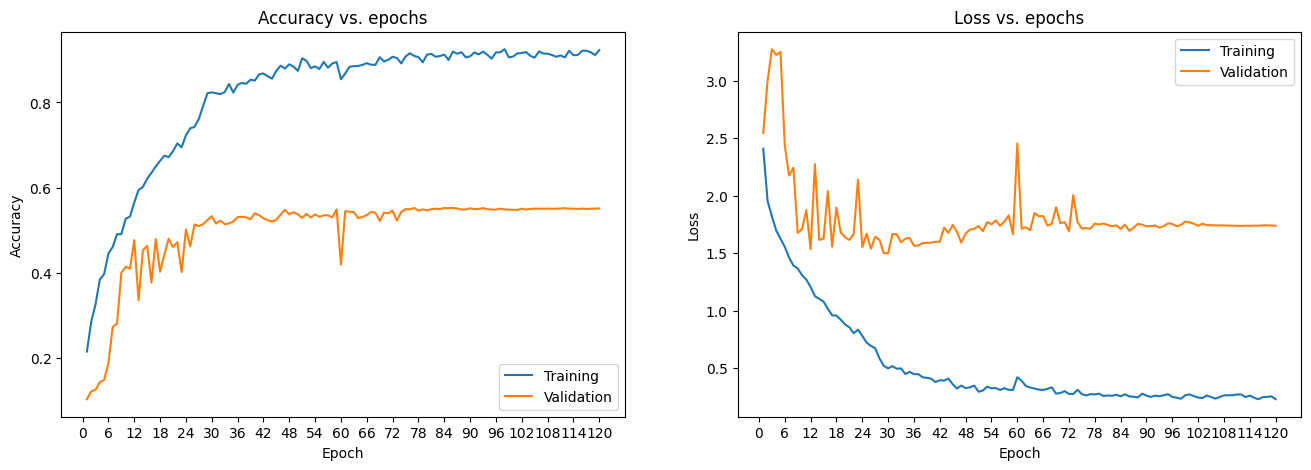

2022-08-09 12:24:07,177: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 12:24:12,757: INFO: test loss:1.6948
2022-08-09 12:24:12,758: INFO: test accuracy:0.5523
2022-08-09 12:24:12,760: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json
2022-08-09 12:24:12,762: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json
2022-08-09 12:24:12,762: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:24:12,763: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:24:12,764: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/le

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:24:13,626: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator


313/313 [==============================] - 1s 2ms/step


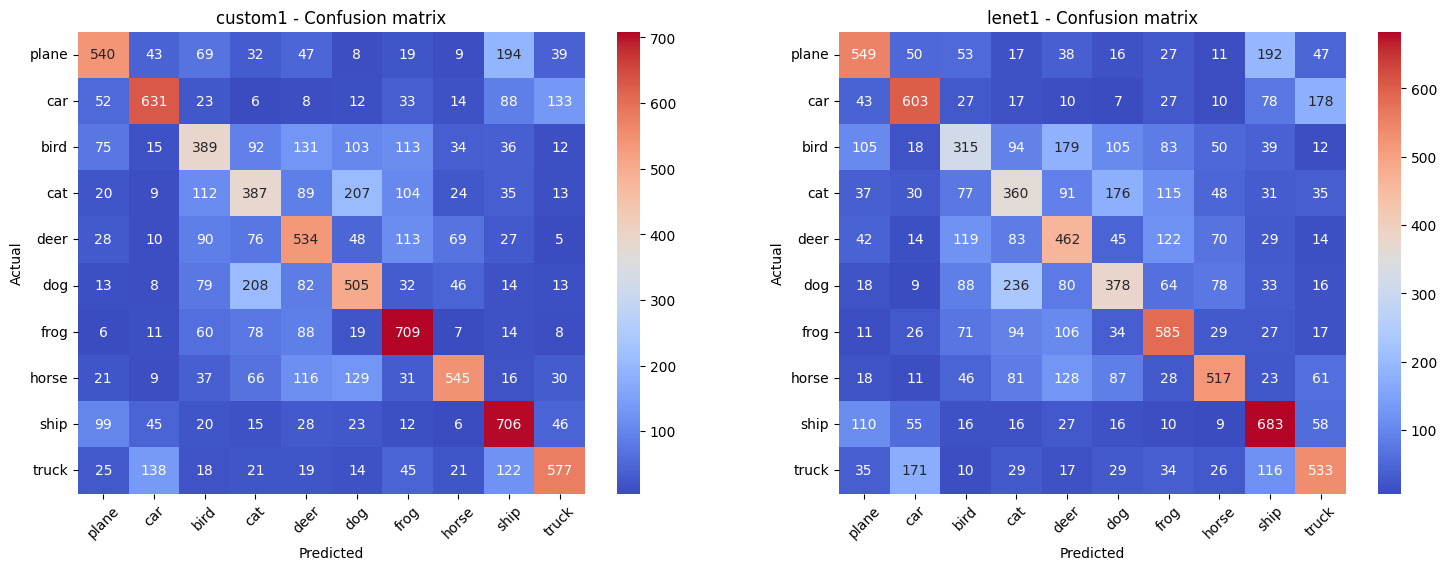

2022-08-09 12:24:18,509: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:24:19,410: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:24:19,412: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1
2022-08-09 12:24:19,725: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:24:19,726: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20
2022-08-09 12:24:24,982: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:24:24,988: INFO: loading model from /tf/eipi10/xuxiangwen.gith

1/1 [==============================] - 0s 11ms/step


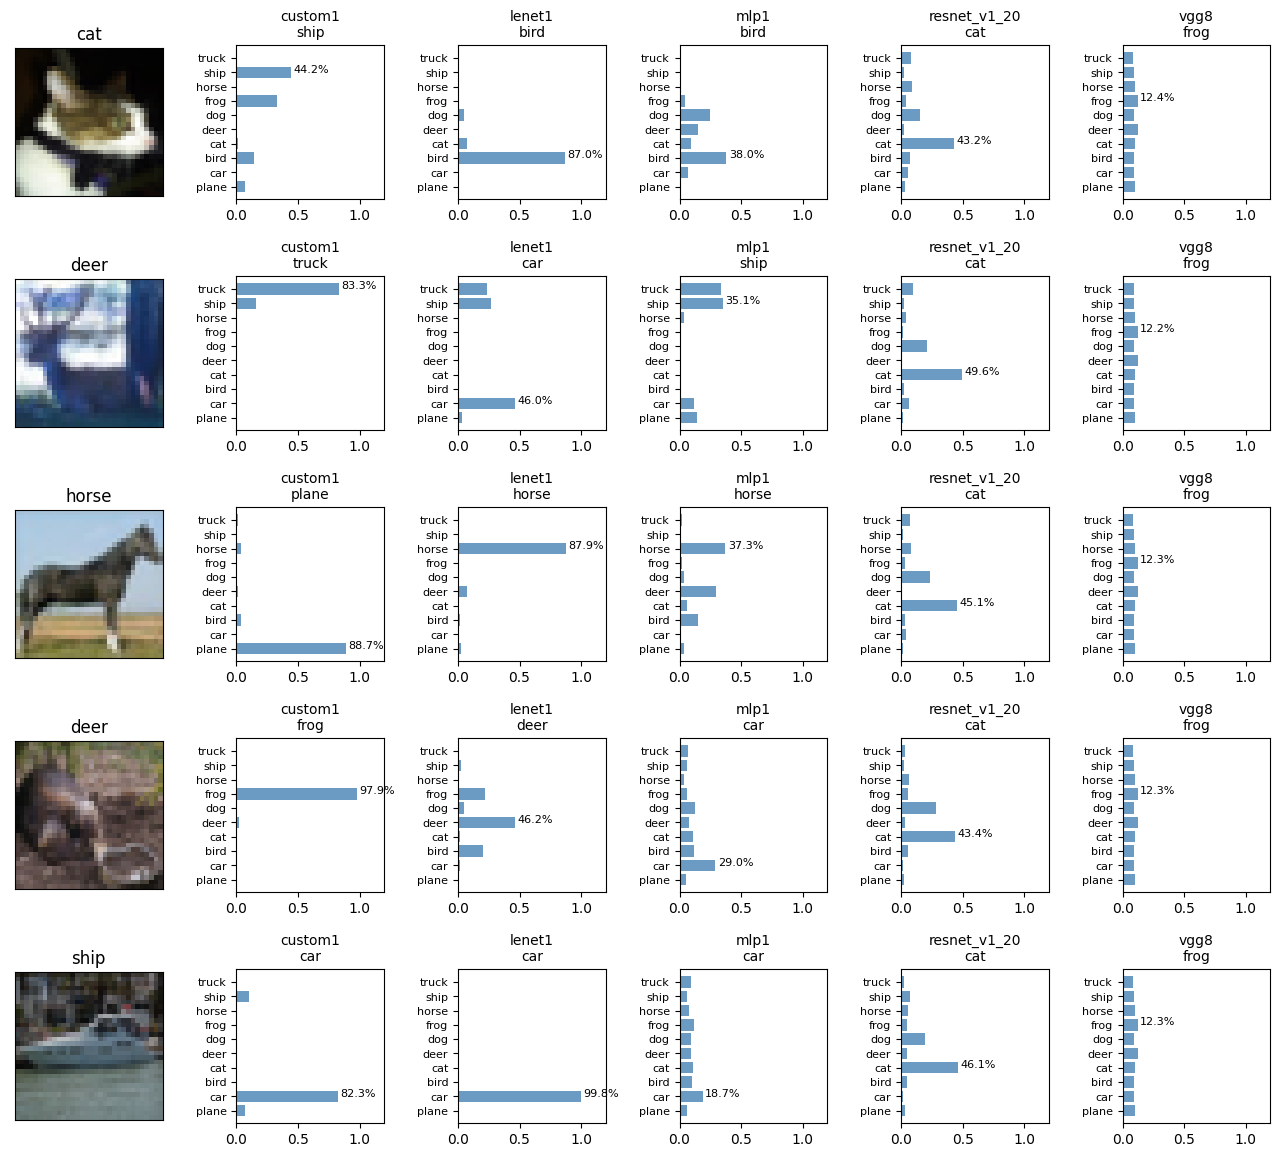

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1       custom1  cifar10_0808_count_200.ipynb          73738       186.9   
2        lenet1  cifar10_0808_count_200.ipynb          83170       157.6   
3          mlp1  cifar10_0808_count_200.ipynb         394634       119.2   
4  resnet_v1_20  cifar10_0808_count_200.ipynb         273066        17.7   
5          vgg8  cifar10_0808_count_200.ipynb        1672906         7.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:24      0.0625     1.6948          0.9945         0.5523   
2  2022-08-09 12:20      0.0952     1.9174          0.9845         0.4985   
3  2022-08-09 12:17      1.5014     1.9329          0.4745         0.3116   
4  2022-08-09 05:43      3.1658     3.1747          0.1030         0.1009   
5  2022-08-09 05:42      2.3108     2.3087          0.0940         0.1000   

   train_auc  test_auc  
1     0.9994    0.9029  
2     0.9992    0.8764  
3     0.8738    0.7674  
4     0.5820    0.5803  
5     0.5300    0.5250

In [31]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2022-08-09 12:24:33,902: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 12:24:34,078: INFO: learning_rate=0.001
2022-08-09 12:24:34,079: INFO: model_params.vgg8.clip_value=None
2022-08-09 12:24:34,085: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                         

2022-08-09 12:24:34,137: INFO: model_params.vgg8.epochs=120
2022-08-09 12:24:34,138: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8, monitor=val_accuracy)
2022-08-09 12:24:34,139: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:24:34,139: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:24:34,140: INFO: use LearningRateScheduler()
2022-08-09 12:24:34,141: INFO: steps_per_epoch=62
2022-08-09 12:24:34,141: INFO: start training
2022-08-09 12:24:34,142: INFO: use_class_weight=False


Epoch 1/120
60/62 [============================>.] - ETA: 0s - loss: 2.5904 - accuracy: 0.1510

2022-08-09 12:24:40,172: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:24:41,362: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 7s 96ms/step - loss: 2.5775 - accuracy: 0.1532 - val_loss: 2.3131 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/120
62/62 [==============================] - 2s 31ms/step - loss: 2.1543 - accuracy: 0.1860 - val_loss: 2.4937 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/120
60/62 [============================>.] - ETA: 0s - loss: 2.0943 - accuracy: 0.2057

2022-08-09 12:24:47,740: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:24:49,365: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 100ms/step - loss: 2.0917 - accuracy: 0.2082 - val_loss: 2.5035 - val_accuracy: 0.1214 - lr: 0.0010
Epoch 4/120
58/62 [===========================>..] - ETA: 0s - loss: 2.0215 - accuracy: 0.2214

2022-08-09 12:24:53,726: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:24:54,918: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 91ms/step - loss: 2.0173 - accuracy: 0.2218 - val_loss: 2.7459 - val_accuracy: 0.1541 - lr: 0.0010
Epoch 5/120
61/62 [============================>.] - ETA: 0s - loss: 1.9773 - accuracy: 0.2382

2022-08-09 12:24:59,377: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:25:00,553: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 92ms/step - loss: 1.9759 - accuracy: 0.2369 - val_loss: 2.6256 - val_accuracy: 0.1618 - lr: 0.0010
Epoch 6/120
62/62 [==============================] - 2s 33ms/step - loss: 1.9166 - accuracy: 0.2440 - val_loss: 2.4402 - val_accuracy: 0.1264 - lr: 0.0010
Epoch 7/120
61/62 [============================>.] - ETA: 0s - loss: 1.9042 - accuracy: 0.2695

2022-08-09 12:25:07,556: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:25:08,743: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 100ms/step - loss: 1.9042 - accuracy: 0.2692 - val_loss: 2.3888 - val_accuracy: 0.1697 - lr: 0.0010
Epoch 8/120
61/62 [============================>.] - ETA: 0s - loss: 1.8835 - accuracy: 0.2536

2022-08-09 12:25:13,283: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:25:14,396: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 92ms/step - loss: 1.8812 - accuracy: 0.2535 - val_loss: 1.9452 - val_accuracy: 0.2498 - lr: 0.0010
Epoch 9/120
61/62 [============================>.] - ETA: 0s - loss: 1.8486 - accuracy: 0.2556

2022-08-09 12:25:18,841: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:25:20,004: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 92ms/step - loss: 1.8490 - accuracy: 0.2560 - val_loss: 1.8450 - val_accuracy: 0.2854 - lr: 0.0010
Epoch 10/120
61/62 [============================>.] - ETA: 0s - loss: 1.8484 - accuracy: 0.2700

2022-08-09 12:25:24,886: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:25:26,049: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 99ms/step - loss: 1.8482 - accuracy: 0.2681 - val_loss: 1.7792 - val_accuracy: 0.3289 - lr: 0.0010
Epoch 11/120
62/62 [==============================] - 2s 33ms/step - loss: 1.8232 - accuracy: 0.2591 - val_loss: 1.9198 - val_accuracy: 0.3057 - lr: 0.0010
Epoch 12/120
62/62 [==============================] - 2s 33ms/step - loss: 1.7996 - accuracy: 0.2737 - val_loss: 1.8964 - val_accuracy: 0.3251 - lr: 0.0010
Epoch 13/120
59/62 [===========================>..] - ETA: 0s - loss: 1.7408 - accuracy: 0.2876

2022-08-09 12:25:34,623: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:25:35,833: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 93ms/step - loss: 1.7390 - accuracy: 0.2863 - val_loss: 1.7016 - val_accuracy: 0.3446 - lr: 0.0010
Epoch 14/120
59/62 [===========================>..] - ETA: 0s - loss: 1.7488 - accuracy: 0.3024

2022-08-09 12:25:40,343: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:25:41,485: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 92ms/step - loss: 1.7450 - accuracy: 0.3044 - val_loss: 1.6480 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 15/120
62/62 [==============================] - 2s 33ms/step - loss: 1.7380 - accuracy: 0.2979 - val_loss: 1.7589 - val_accuracy: 0.3558 - lr: 0.0010
Epoch 16/120
62/62 [==============================] - 2s 32ms/step - loss: 1.7254 - accuracy: 0.3241 - val_loss: 1.8977 - val_accuracy: 0.3348 - lr: 0.0010
Epoch 17/120
61/62 [============================>.] - ETA: 0s - loss: 1.6804 - accuracy: 0.3212

2022-08-09 12:25:50,469: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:25:51,730: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 103ms/step - loss: 1.6807 - accuracy: 0.3216 - val_loss: 1.7576 - val_accuracy: 0.3635 - lr: 0.0010
Epoch 18/120
62/62 [==============================] - 2s 33ms/step - loss: 1.6861 - accuracy: 0.3105 - val_loss: 1.8358 - val_accuracy: 0.3245 - lr: 0.0010
Epoch 19/120
62/62 [==============================] - 2s 33ms/step - loss: 1.6810 - accuracy: 0.3327 - val_loss: 1.8454 - val_accuracy: 0.3315 - lr: 0.0010
Epoch 20/120
60/62 [============================>.] - ETA: 0s - loss: 1.6989 - accuracy: 0.3021

2022-08-09 12:26:00,266: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:26:01,429: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 92ms/step - loss: 1.6996 - accuracy: 0.3014 - val_loss: 1.6181 - val_accuracy: 0.3795 - lr: 0.0010
Epoch 21/120
62/62 [==============================] - 2s 32ms/step - loss: 1.6459 - accuracy: 0.3387 - val_loss: 1.6398 - val_accuracy: 0.3716 - lr: 0.0010
Epoch 22/120
61/62 [============================>.] - ETA: 0s - loss: 1.6017 - accuracy: 0.3535

2022-08-09 12:26:07,909: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:26:09,541: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 101ms/step - loss: 1.6020 - accuracy: 0.3533 - val_loss: 1.6093 - val_accuracy: 0.3942 - lr: 0.0010
Epoch 23/120
62/62 [==============================] - 2s 34ms/step - loss: 1.5822 - accuracy: 0.3584 - val_loss: 1.7963 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 24/120
62/62 [==============================] - 2s 32ms/step - loss: 1.5816 - accuracy: 0.3503 - val_loss: 1.7599 - val_accuracy: 0.3331 - lr: 0.0010
Epoch 25/120
62/62 [==============================] - 2s 33ms/step - loss: 1.5753 - accuracy: 0.3669 - val_loss: 1.7551 - val_accuracy: 0.3904 - lr: 0.0010
Epoch 26/120
62/62 [==============================] - 2s 34ms/step - loss: 1.5748 - accuracy: 0.3659 - val_loss: 1.8944 - val_accuracy: 0.3728 - lr: 0.0010
Epoch 27/120
62/62 [==============================] - ETA: 0s - loss: 1.5881 - accuracy: 0.3674

2022-08-09 12:26:22,274: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:26:23,410: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 93ms/step - loss: 1.5881 - accuracy: 0.3674 - val_loss: 1.5279 - val_accuracy: 0.4203 - lr: 0.0010
Epoch 28/120
62/62 [==============================] - 2s 32ms/step - loss: 1.5621 - accuracy: 0.3548 - val_loss: 1.8800 - val_accuracy: 0.3525 - lr: 0.0010
Epoch 29/120
62/62 [==============================] - 2s 34ms/step - loss: 1.5325 - accuracy: 0.3684 - val_loss: 1.6355 - val_accuracy: 0.4098 - lr: 0.0010
Epoch 30/120
59/62 [===========================>..] - ETA: 0s - loss: 1.5311 - accuracy: 0.3861

2022-08-09 12:26:32,011: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:26:33,155: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 93ms/step - loss: 1.5357 - accuracy: 0.3836 - val_loss: 1.4879 - val_accuracy: 0.4384 - lr: 0.0010
Epoch 31/120
62/62 [==============================] - 2s 33ms/step - loss: 1.4835 - accuracy: 0.3952 - val_loss: 1.6476 - val_accuracy: 0.3695 - lr: 0.0010
Epoch 32/120
62/62 [==============================] - 2s 33ms/step - loss: 1.4579 - accuracy: 0.3947 - val_loss: 1.5766 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 33/120
62/62 [==============================] - 2s 33ms/step - loss: 1.4716 - accuracy: 0.3881 - val_loss: 1.7403 - val_accuracy: 0.3488 - lr: 0.0010
Epoch 34/120
61/62 [============================>.] - ETA: 0s - loss: 1.4785 - accuracy: 0.3832

2022-08-09 12:26:44,228: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:26:45,408: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 101ms/step - loss: 1.4833 - accuracy: 0.3816 - val_loss: 1.5633 - val_accuracy: 0.4416 - lr: 0.0010
Epoch 35/120
62/62 [==============================] - 2s 33ms/step - loss: 1.4719 - accuracy: 0.3805 - val_loss: 1.6525 - val_accuracy: 0.3825 - lr: 0.0010
Epoch 36/120
62/62 [==============================] - 2s 33ms/step - loss: 1.4885 - accuracy: 0.3896 - val_loss: 1.5472 - val_accuracy: 0.4317 - lr: 0.0010
Epoch 37/120
62/62 [==============================] - 2s 33ms/step - loss: 1.4662 - accuracy: 0.3931 - val_loss: 1.7319 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 38/120
62/62 [==============================] - 2s 32ms/step - loss: 1.4397 - accuracy: 0.4062 - val_loss: 1.6417 - val_accuracy: 0.4325 - lr: 0.0010
Epoch 39/120
62/62 [==============================] - ETA: 0s - loss: 1.4142 - accuracy: 0.4204

2022-08-09 12:26:58,088: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:26:59,285: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 95ms/step - loss: 1.4142 - accuracy: 0.4204 - val_loss: 1.4517 - val_accuracy: 0.4698 - lr: 0.0010
Epoch 40/120
62/62 [==============================] - 2s 33ms/step - loss: 1.3934 - accuracy: 0.4274 - val_loss: 1.5344 - val_accuracy: 0.4176 - lr: 0.0010
Epoch 41/120
62/62 [==============================] - 2s 33ms/step - loss: 1.4036 - accuracy: 0.4168 - val_loss: 1.4881 - val_accuracy: 0.4473 - lr: 0.0010
Epoch 42/120
62/62 [==============================] - 2s 32ms/step - loss: 1.3695 - accuracy: 0.4370 - val_loss: 1.7388 - val_accuracy: 0.3698 - lr: 0.0010
Epoch 43/120
62/62 [==============================] - 2s 33ms/step - loss: 1.4286 - accuracy: 0.3947 - val_loss: 1.7496 - val_accuracy: 0.4107 - lr: 0.0010
Epoch 44/120
62/62 [==============================] - 2s 33ms/step - loss: 1.3877 - accuracy: 0.4189 - val_loss: 1.5763 - val_accuracy: 0.4475 - lr: 0.0010
Epoch 45/120
62/62 [==============================] - 2s 33ms/step - loss: 1.

2022-08-09 12:27:29,945: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:27:31,196: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 92ms/step - loss: 1.2837 - accuracy: 0.4753 - val_loss: 1.6085 - val_accuracy: 0.4719 - lr: 0.0010
Epoch 54/120
62/62 [==============================] - ETA: 0s - loss: 1.2957 - accuracy: 0.4511
Epoch 54: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
62/62 [==============================] - 2s 32ms/step - loss: 1.2957 - accuracy: 0.4511 - val_loss: 1.5012 - val_accuracy: 0.4632 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/120
58/62 [===========================>..] - ETA: 0s - loss: 1.2451 - accuracy: 0.4693

2022-08-09 12:27:38,159: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:27:39,325: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 100ms/step - loss: 1.2443 - accuracy: 0.4698 - val_loss: 1.4193 - val_accuracy: 0.5081 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/120
61/62 [============================>.] - ETA: 0s - loss: 1.1958 - accuracy: 0.4857

2022-08-09 12:27:43,766: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:27:44,908: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 91ms/step - loss: 1.2001 - accuracy: 0.4844 - val_loss: 1.3785 - val_accuracy: 0.5152 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/120
62/62 [==============================] - 2s 34ms/step - loss: 1.1470 - accuracy: 0.4995 - val_loss: 1.4275 - val_accuracy: 0.5010 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/120
62/62 [==============================] - 2s 34ms/step - loss: 1.1735 - accuracy: 0.4975 - val_loss: 1.4456 - val_accuracy: 0.5038 - lr: 3.1623e-04
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 59/120
62/62 [==============================] - 2s 30ms/step - loss: 1.1402 - accuracy: 0.5161 - val_loss: 1.5779 - val_accuracy: 0.5015 - lr: 3.1623e-04
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
Epoch 60/120
62/62 [==============================] - 2s 33ms/step - loss: 1.1298 - accuracy: 0.5071 - val_loss: 

2022-08-09 12:27:57,498: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:27:59,128: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 101ms/step - loss: 1.1009 - accuracy: 0.5222 - val_loss: 1.4060 - val_accuracy: 0.5208 - lr: 1.0000e-04
Epoch 62/120
61/62 [============================>.] - ETA: 0s - loss: 1.0881 - accuracy: 0.5394

2022-08-09 12:28:03,672: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:28:04,868: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 93ms/step - loss: 1.0879 - accuracy: 0.5403 - val_loss: 1.3941 - val_accuracy: 0.5242 - lr: 1.0000e-04
Epoch 63/120
62/62 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.5307

2022-08-09 12:28:09,457: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:28:10,624: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 94ms/step - loss: 1.1004 - accuracy: 0.5307 - val_loss: 1.4119 - val_accuracy: 0.5301 - lr: 1.0000e-04
Epoch 64/120
62/62 [==============================] - 2s 33ms/step - loss: 1.1066 - accuracy: 0.5192 - val_loss: 1.4306 - val_accuracy: 0.5225 - lr: 1.0000e-04
Epoch 65/120
62/62 [==============================] - 2s 32ms/step - loss: 1.0986 - accuracy: 0.5277 - val_loss: 1.4106 - val_accuracy: 0.5230 - lr: 1.0000e-04
Epoch 66/120
62/62 [==============================] - 2s 33ms/step - loss: 1.0729 - accuracy: 0.5423 - val_loss: 1.4382 - val_accuracy: 0.5224 - lr: 1.0000e-04
Epoch 67/120
62/62 [==============================] - 2s 34ms/step - loss: 1.0994 - accuracy: 0.5312 - val_loss: 1.4066 - val_accuracy: 0.5257 - lr: 1.0000e-04
Epoch 68/120
61/62 [============================>.] - ETA: 0s - loss: 1.1050 - accuracy: 0.5210

2022-08-09 12:28:23,722: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:28:24,931: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 102ms/step - loss: 1.1060 - accuracy: 0.5207 - val_loss: 1.4203 - val_accuracy: 0.5319 - lr: 1.0000e-04
Epoch 69/120
62/62 [==============================] - 2s 34ms/step - loss: 1.0671 - accuracy: 0.5444 - val_loss: 1.4419 - val_accuracy: 0.5248 - lr: 1.0000e-04
Epoch 70/120
62/62 [==============================] - ETA: 0s - loss: 1.0648 - accuracy: 0.5444

2022-08-09 12:28:31,898: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


2022-08-09 12:28:33,092: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8/assets


62/62 [==============================] - 6s 99ms/step - loss: 1.0648 - accuracy: 0.5444 - val_loss: 1.4245 - val_accuracy: 0.5332 - lr: 1.0000e-04
Epoch 71/120
59/62 [===========================>..] - ETA: 0s - loss: 1.0440 - accuracy: 0.5588
Epoch 71: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
62/62 [==============================] - 2s 33ms/step - loss: 1.0509 - accuracy: 0.5565 - val_loss: 1.4126 - val_accuracy: 0.5216 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/120
62/62 [==============================] - 2s 32ms/step - loss: 1.0419 - accuracy: 0.5363 - val_loss: 1.4154 - val_accuracy: 0.5224 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/120
62/62 [==============================] - 2s 34ms/step - loss: 1.0460 - accuracy: 0.5459 - val_loss: 1.4193 - val_accuracy: 0.5285 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/120
62/6

62/62 [==============================] - 2s 31ms/step - loss: 1.0440 - accuracy: 0.5358 - val_loss: 1.4437 - val_accuracy: 0.5330 - lr: 1.0000e-06
Epoch 109/120
62/62 [==============================] - 2s 34ms/step - loss: 1.0129 - accuracy: 0.5721 - val_loss: 1.4424 - val_accuracy: 0.5330 - lr: 1.0000e-06
Epoch 110/120
62/62 [==============================] - 2s 32ms/step - loss: 1.0092 - accuracy: 0.5605 - val_loss: 1.4427 - val_accuracy: 0.5332 - lr: 1.0000e-06
Epoch 110: early stopping


2022-08-09 12:29:53,754: INFO: finish training [elapsed time: 319.61 seconds]


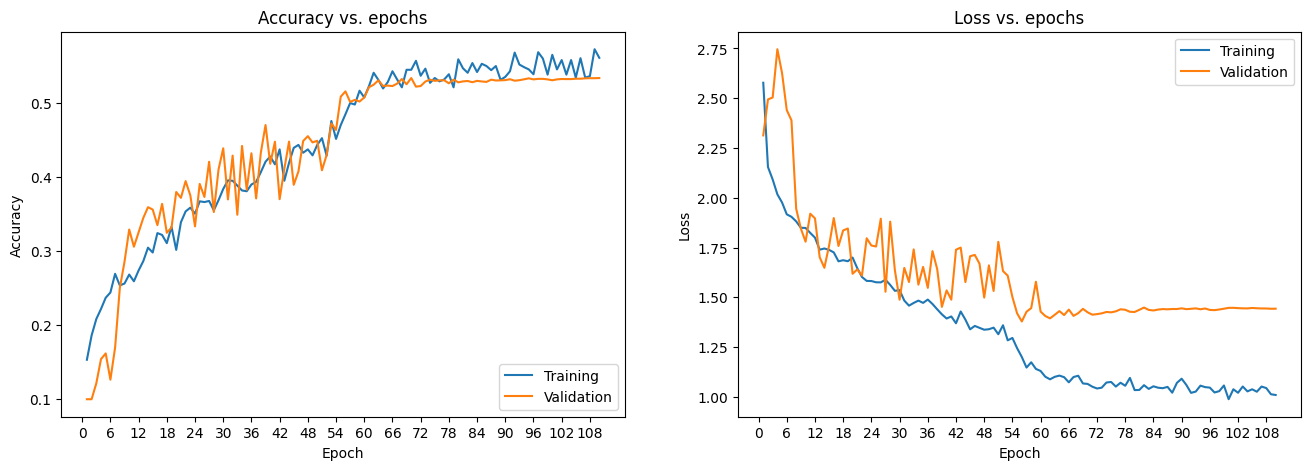

2022-08-09 12:29:54,215: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-09 12:30:01,281: INFO: test loss:1.4245
2022-08-09 12:30:01,282: INFO: test accuracy:0.5332
2022-08-09 12:30:01,283: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json
2022-08-09 12:30:01,285: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json
2022-08-09 12:30:01,286: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:30:01,287: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:30:01,288: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/cu

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:30:02,253: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator


313/313 [==============================] - 1s 3ms/step


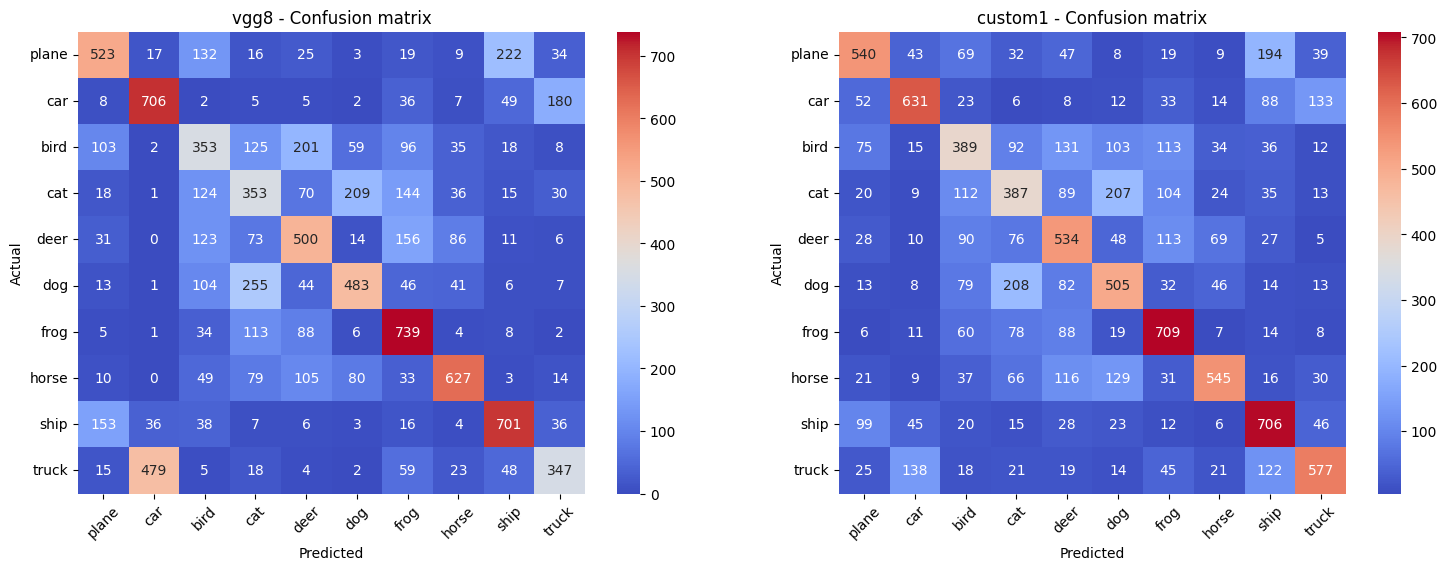

2022-08-09 12:30:08,135: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:30:09,182: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:30:09,188: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1
2022-08-09 12:30:10,087: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:30:10,091: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/mlp1
2022-08-09 12:30:10,387: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:30:10,390: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/

1/1 [==============================] - 0s 14ms/step


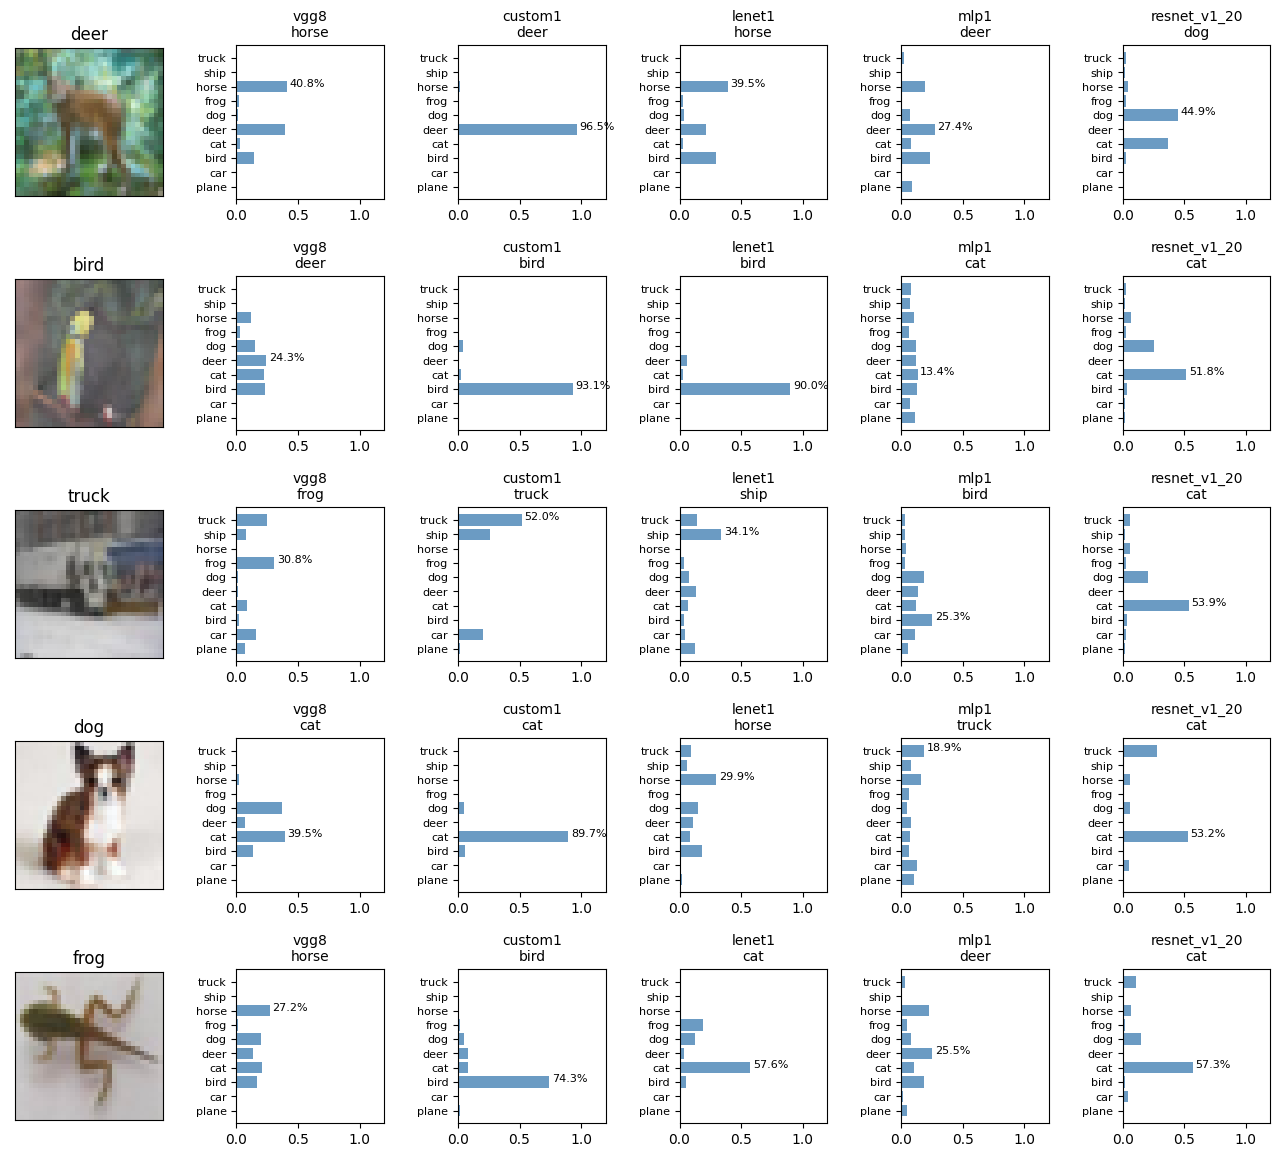

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1       custom1  cifar10_0808_count_200.ipynb          73738       186.9   
2          vgg8  cifar10_0808_count_200.ipynb        1672906       319.6   
3        lenet1  cifar10_0808_count_200.ipynb          83170       157.6   
4          mlp1  cifar10_0808_count_200.ipynb         394634       119.2   
5  resnet_v1_20  cifar10_0808_count_200.ipynb         273066        17.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:24      0.0625     1.6948          0.9945         0.5523   
2  2022-08-09 12:30      0.6132     1.4245          0.8220         0.5332   
3  2022-08-09 12:20      0.0952     1.9174          0.9845         0.4985   
4  2022-08-09 12:17      1.5014     1.9329          0.4745         0.3116   
5  2022-08-09 05:43      3.1658     3.1747          0.1030         0.1009   

   train_auc  test_auc  
1     0.9994    0.9029  
2     0.9853    0.9035  
3     0.9992    0.8764  
4     0.8738    0.7674  
5     0.5820    0.5803

In [32]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 12:30:23,445: INFO: learning_rate=0.001
2022-08-09 12:30:23,446: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-09 12:30:23,453: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization_

                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_15 (BatchN  (None, 16, 16, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (Dense)                (None, 10)           650         ['flatten_4[0][0]']              
                                                                                                  
Total para

2022-08-09 12:30:23,572: INFO: model_params.resnet_v1_20.epochs=80
2022-08-09 12:30:23,573: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20, monitor=val_accuracy)
2022-08-09 12:30:23,573: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:30:23,574: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:30:23,574: INFO: use LearningRateScheduler()
2022-08-09 12:30:23,575: INFO: steps_per_epoch=62
2022-08-09 12:30:23,576: INFO: start training
2022-08-09 12:30:23,576: INFO: use_class_weight=False


Epoch 1/80
61/62 [============================>.] - ETA: 0s - loss: 2.5630 - accuracy: 0.2223

2022-08-09 12:30:38,981: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:30:42,163: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


62/62 [==============================] - 19s 253ms/step - loss: 2.5528 - accuracy: 0.2233 - val_loss: 3.1703 - val_accuracy: 0.1296 - lr: 0.0010
Epoch 2/80
62/62 [==============================] - ETA: 0s - loss: 1.8994 - accuracy: 0.3548

2022-08-09 12:30:53,418: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:30:56,588: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


62/62 [==============================] - 14s 236ms/step - loss: 1.8994 - accuracy: 0.3548 - val_loss: 2.2783 - val_accuracy: 0.2166 - lr: 0.0010
Epoch 3/80
62/62 [==============================] - 3s 55ms/step - loss: 1.6742 - accuracy: 0.4375 - val_loss: 2.6005 - val_accuracy: 0.2138 - lr: 0.0010
Epoch 4/80
62/62 [==============================] - 3s 56ms/step - loss: 1.4561 - accuracy: 0.5418 - val_loss: 2.7041 - val_accuracy: 0.2099 - lr: 0.0010
Epoch 5/80
62/62 [==============================] - 3s 52ms/step - loss: 1.2145 - accuracy: 0.6316 - val_loss: 2.9177 - val_accuracy: 0.2110 - lr: 0.0010
Epoch 6/80
61/62 [============================>.] - ETA: 0s - loss: 1.0242 - accuracy: 0.7039

2022-08-09 12:31:17,581: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:31:20,717: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


62/62 [==============================] - 14s 231ms/step - loss: 1.0255 - accuracy: 0.7026 - val_loss: 2.8375 - val_accuracy: 0.2580 - lr: 0.0010
Epoch 7/80
61/62 [============================>.] - ETA: 0s - loss: 0.9273 - accuracy: 0.7280

2022-08-09 12:31:31,667: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:31:34,822: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


62/62 [==============================] - 14s 231ms/step - loss: 0.9291 - accuracy: 0.7268 - val_loss: 3.0819 - val_accuracy: 0.2704 - lr: 0.0010
Epoch 8/80
62/62 [==============================] - 4s 70ms/step - loss: 0.8389 - accuracy: 0.7591 - val_loss: 6.4927 - val_accuracy: 0.1768 - lr: 0.0010
Epoch 9/80
62/62 [==============================] - 4s 65ms/step - loss: 0.7118 - accuracy: 0.8120 - val_loss: 6.1164 - val_accuracy: 0.1954 - lr: 0.0010
Epoch 10/80
61/62 [============================>.] - ETA: 0s - loss: 0.5354 - accuracy: 0.8781

2022-08-09 12:31:54,408: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:31:57,537: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


62/62 [==============================] - 14s 236ms/step - loss: 0.5346 - accuracy: 0.8780 - val_loss: 3.1776 - val_accuracy: 0.2837 - lr: 0.0010
Epoch 11/80
62/62 [==============================] - 3s 52ms/step - loss: 0.4362 - accuracy: 0.9178 - val_loss: 9.1394 - val_accuracy: 0.1569 - lr: 0.0010
Epoch 12/80
62/62 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.9315

2022-08-09 12:32:12,936: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:32:16,129: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


62/62 [==============================] - 15s 252ms/step - loss: 0.4051 - accuracy: 0.9315 - val_loss: 3.9629 - val_accuracy: 0.3010 - lr: 0.0010
Epoch 13/80
60/62 [============================>.] - ETA: 0s - loss: 0.3589 - accuracy: 0.9495

2022-08-09 12:32:28,209: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:32:31,461: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


62/62 [==============================] - 15s 251ms/step - loss: 0.3556 - accuracy: 0.9506 - val_loss: 4.0726 - val_accuracy: 0.3045 - lr: 0.0010
Epoch 14/80
62/62 [==============================] - 3s 53ms/step - loss: 0.2930 - accuracy: 0.9677 - val_loss: 5.0990 - val_accuracy: 0.2537 - lr: 0.0010
Epoch 15/80
62/62 [==============================] - 4s 70ms/step - loss: 0.2713 - accuracy: 0.9758 - val_loss: 5.0963 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 16/80
61/62 [============================>.] - ETA: 0s - loss: 0.2298 - accuracy: 0.9867

2022-08-09 12:32:50,022: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:32:53,206: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


62/62 [==============================] - 14s 233ms/step - loss: 0.2295 - accuracy: 0.9869 - val_loss: 3.3953 - val_accuracy: 0.3512 - lr: 0.0010
Epoch 17/80
61/62 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9928

2022-08-09 12:33:04,794: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:33:07,987: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
62/62 [==============================] - 15s 242ms/step - loss: 0.2149 - accuracy: 0.9924 - val_loss: 3.7151 - val_accuracy: 0.3594 - lr: 3.1623e-04
Epoch 00018: Still keep learning rate 0.0003162 instead of 0.001
Epoch 18/80
61/62 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9964

2022-08-09 12:33:19,078: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:33:22,365: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


62/62 [==============================] - 14s 235ms/step - loss: 0.1890 - accuracy: 0.9965 - val_loss: 2.7627 - val_accuracy: 0.4061 - lr: 3.1623e-04
Epoch 00019: Still keep learning rate 0.0003162 instead of 0.001
Epoch 19/80
61/62 [============================>.] - ETA: 0s - loss: 0.1754 - accuracy: 1.0000

2022-08-09 12:33:34,510: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


2022-08-09 12:33:37,912: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20/assets


62/62 [==============================] - 16s 254ms/step - loss: 0.1754 - accuracy: 1.0000 - val_loss: 2.7052 - val_accuracy: 0.4121 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/80
62/62 [==============================] - 3s 56ms/step - loss: 0.1740 - accuracy: 1.0000 - val_loss: 2.7025 - val_accuracy: 0.4100 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/80
62/62 [==============================] - 4s 61ms/step - loss: 0.1731 - accuracy: 1.0000 - val_loss: 2.7087 - val_accuracy: 0.4098 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/80
62/62 [==============================] - 4s 71ms/step - loss: 0.1723 - accuracy: 1.0000 - val_loss: 2.7159 - val_accuracy: 0.4093 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/80
62/62 [==============================] - 4s 69ms/step - loss: 0.1717 - accuracy: 1.0000 - val_loss: 2.

62/62 [==============================] - 4s 69ms/step - loss: 0.1354 - accuracy: 1.0000 - val_loss: 2.7983 - val_accuracy: 0.4004 - lr: 0.0010
Epoch 58/80
62/62 [==============================] - 6s 89ms/step - loss: 0.1327 - accuracy: 1.0000 - val_loss: 2.8020 - val_accuracy: 0.4003 - lr: 0.0010
Epoch 59/80
62/62 [==============================] - 6s 90ms/step - loss: 0.1301 - accuracy: 1.0000 - val_loss: 2.8055 - val_accuracy: 0.4001 - lr: 0.0010
Epoch 59: early stopping


2022-08-09 12:36:23,976: INFO: finish training [elapsed time: 360.40 seconds]


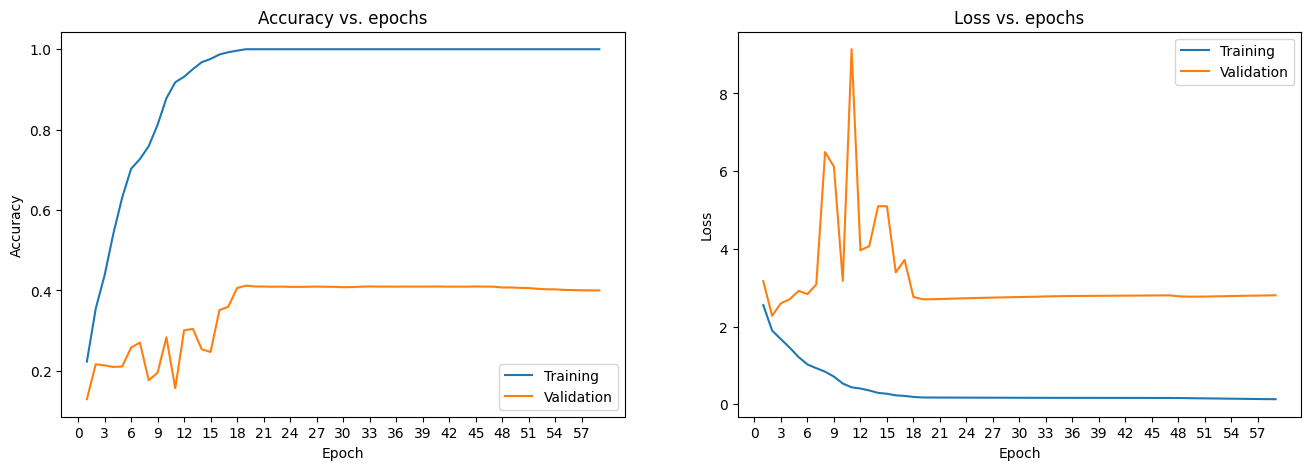

2022-08-09 12:36:24,413: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 7ms/step


2022-08-09 12:36:38,425: INFO: test loss:2.7052
2022-08-09 12:36:38,425: INFO: test accuracy:0.4121
2022-08-09 12:36:38,429: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json
2022-08-09 12:36:38,431: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/results.json
2022-08-09 12:36:38,432: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:36:38,433: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:36:38,434: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/cu

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:36:40,334: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator


313/313 [==============================] - 1s 3ms/step


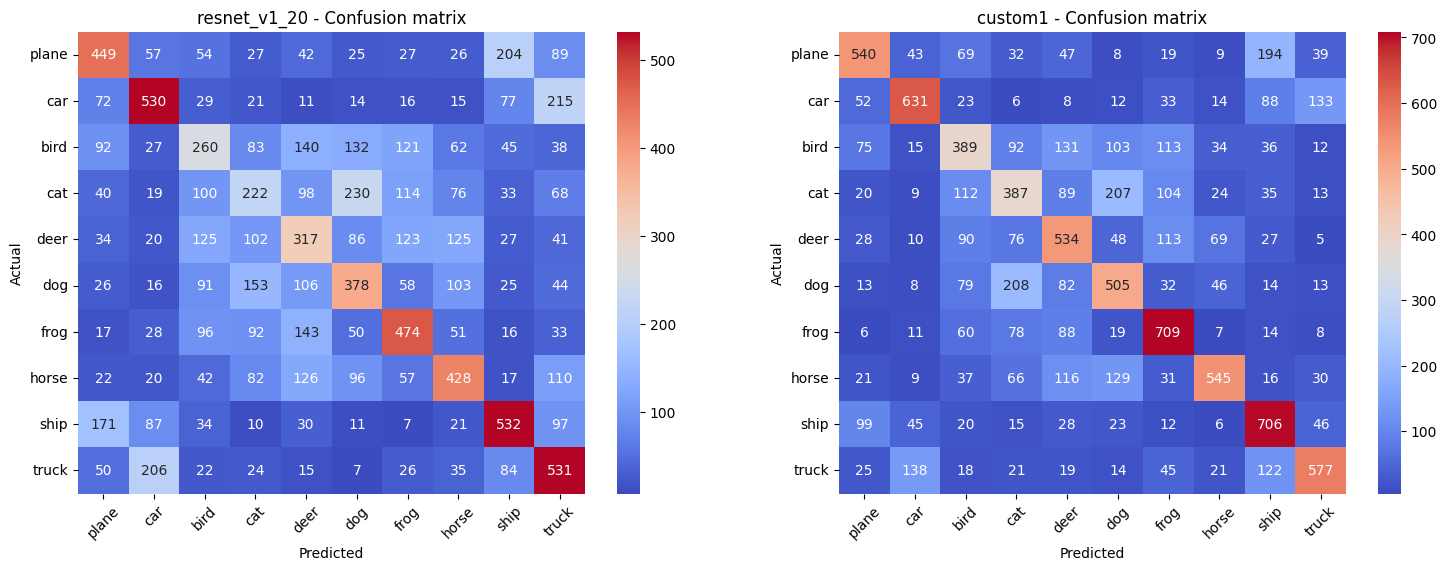

2022-08-09 12:36:46,981: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/custom1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:36:48,020: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:36:48,025: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/vgg8
2022-08-09 12:36:49,767: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:36:49,774: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/lenet1
2022-08-09 12:36:50,707: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_200/default.generator
2022-08-09 12:36:50,712: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/

1/1 [==============================] - 0s 12ms/step


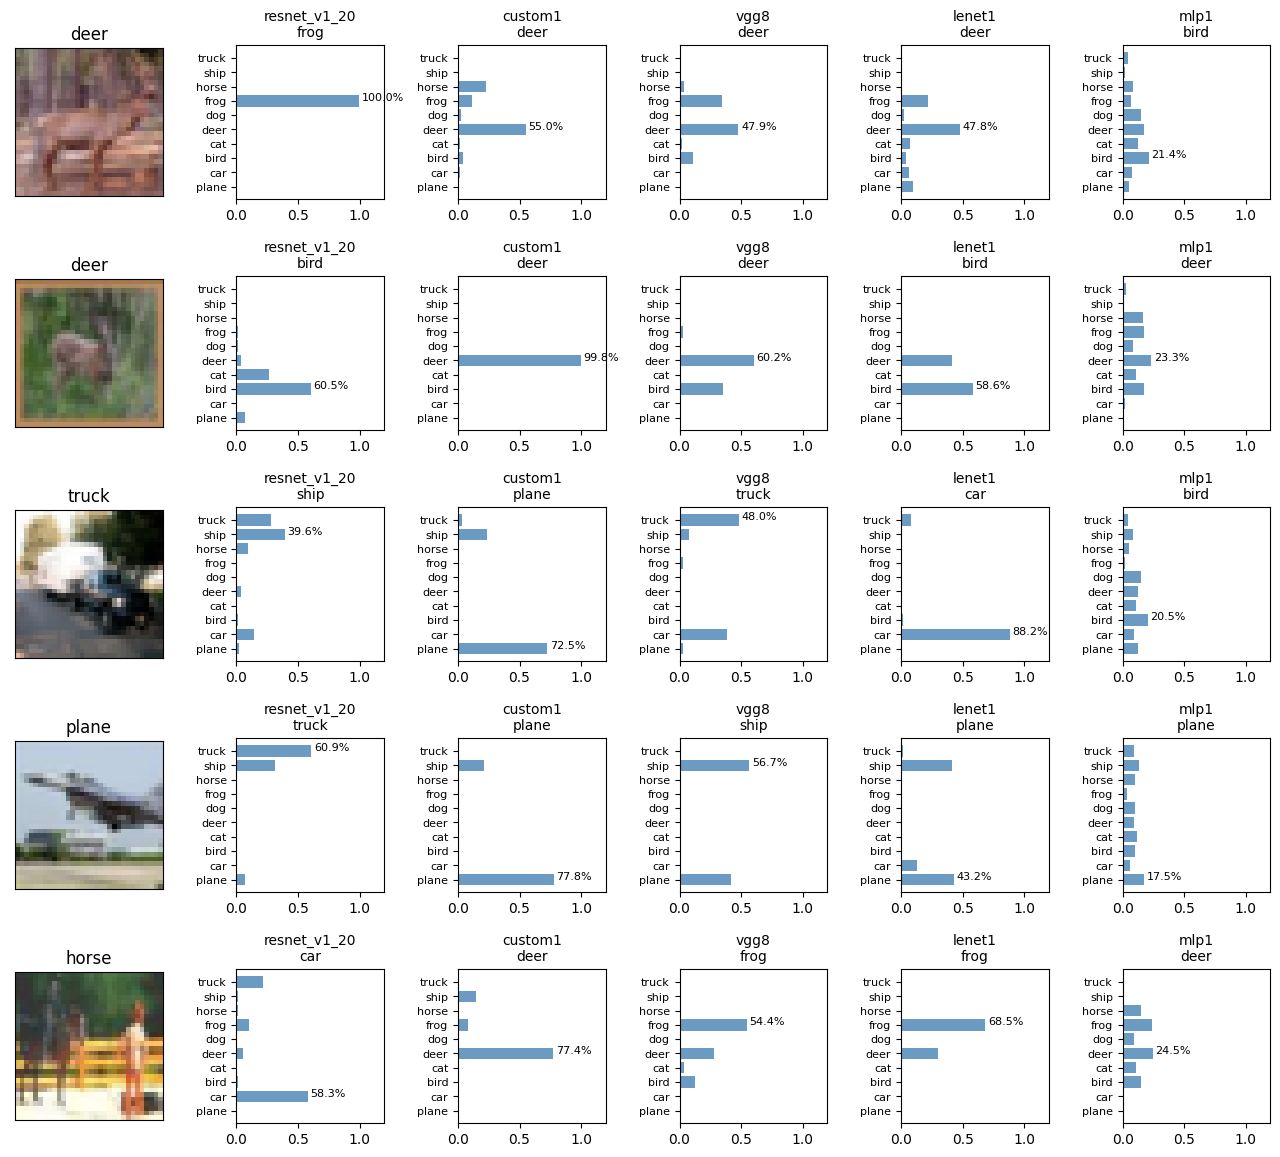

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1       custom1  cifar10_0808_count_200.ipynb          73738       186.9   
2          vgg8  cifar10_0808_count_200.ipynb        1672906       319.6   
3        lenet1  cifar10_0808_count_200.ipynb          83170       157.6   
4  resnet_v1_20  cifar10_0808_count_200.ipynb         273066       360.4   
5          mlp1  cifar10_0808_count_200.ipynb         394634       119.2   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:24      0.0625     1.6948          0.9945         0.5523   
2  2022-08-09 12:30      0.6132     1.4245          0.8220         0.5332   
3  2022-08-09 12:20      0.0952     1.9174          0.9845         0.4985   
4  2022-08-09 12:36      0.2088     2.7052          0.9940         0.4121   
5  2022-08-09 12:17      1.5014     1.9329          0.4745         0.3116   

   train_auc  test_auc  
1     0.9994    0.9029  
2     0.9853    0.9035  
3     0.9992    0.8764  
4     0.9993    0.8251  
5     0.8738    0.7674

In [33]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [34]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-09 12:36:59,544: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-09 12:36:59,546: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2022-08-09 12:36:59,547: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 12:36:59,549: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 12:36:59,550: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 12:36:59,551: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflo

model_name                   program_name  weight_number  train_time  \
1           vgg8        cifar10_0808_p100.ipynb        1672906      2759.0   
2           vgg8        cifar10_0721_p100.ipynb        1672906      2195.2   
3           vgg8  cifar10_0808_count_5000.ipynb        1672906      1973.9   
4           vgg8  cifar10_0808_count_2000.ipynb        1672906      1399.2   
5   resnet_v1_20        cifar10_0808_p100.ipynb         273066      3631.9   
6   resnet_v1_20  cifar10_0808_count_5000.ipynb         273066      2984.0   
7   resnet_v1_20        cifar10_0721_p100.ipynb         273066      4091.3   
8        custom1        cifar10_0808_p100.ipynb          73738       849.4   
9        custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
10       custom1        cifar10_0721_p100.ipynb          73738      1190.8   

         create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1   2022-08-09 10:18      0.0017     0.5896          0.9997         0.8968   
2   2021-12-02 08:49      0.0029     0.5959          0.9995         0.8921   
3   2022-08-09 07:07      0.0044     0.5588          0.9991         0.8873   
4   2022-08-09 10:22      0.0064     0.8481          0.9987         0.8418   
5   2022-08-09 11:19      0.1058     1.3800          0.9979         0.8262   
6   2022-08-09 07:58      0.2096     1.1902          0.9986         0.8252   
7   2021-12-02 09:58      0.1180     1.3054          0.9985         0.8197   
8   2022-08-09 09:31      0.3383     0.5942          0.8858         0.8009   
9   2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
10  2021-12-02 08:12      0.3420     0.6094          0.8832         0.7947   

    train_auc  test_auc  
1      1.0000    0.9922  
2      1.0000    0.9920  
3      1.0000    0.9919  
4      1.0000    0.9838  
5      1.0000    0.9796  
6      1.0000    0.9810  
7      1.0000    0.9791  
8      0.9926    0.9778  
9      0.9934    0.9776  
10     0.9929    0.9776

In [35]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-09 12:36:59,692: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8
2022-08-09 12:37:01,378: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 12:37:01,387: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
2022-08-09 12:37:03,244: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2022-08-09 12:37:03,255: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8
2022-08-09 12:37:04,923: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_c

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 0s 13ms/step


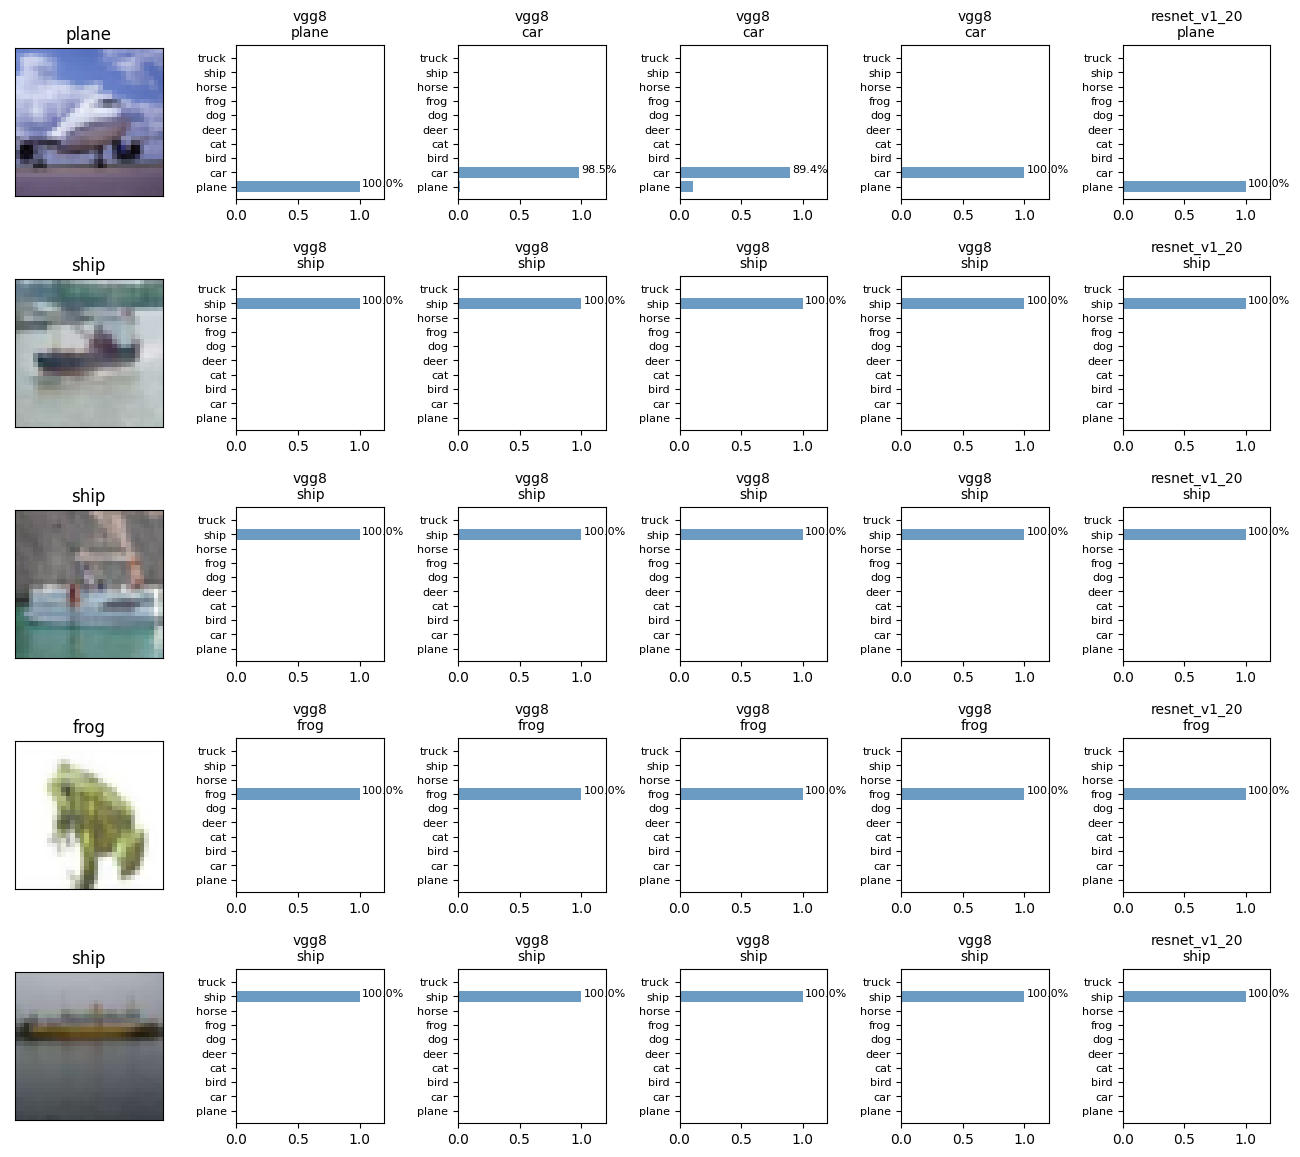

In [36]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 16ms/step


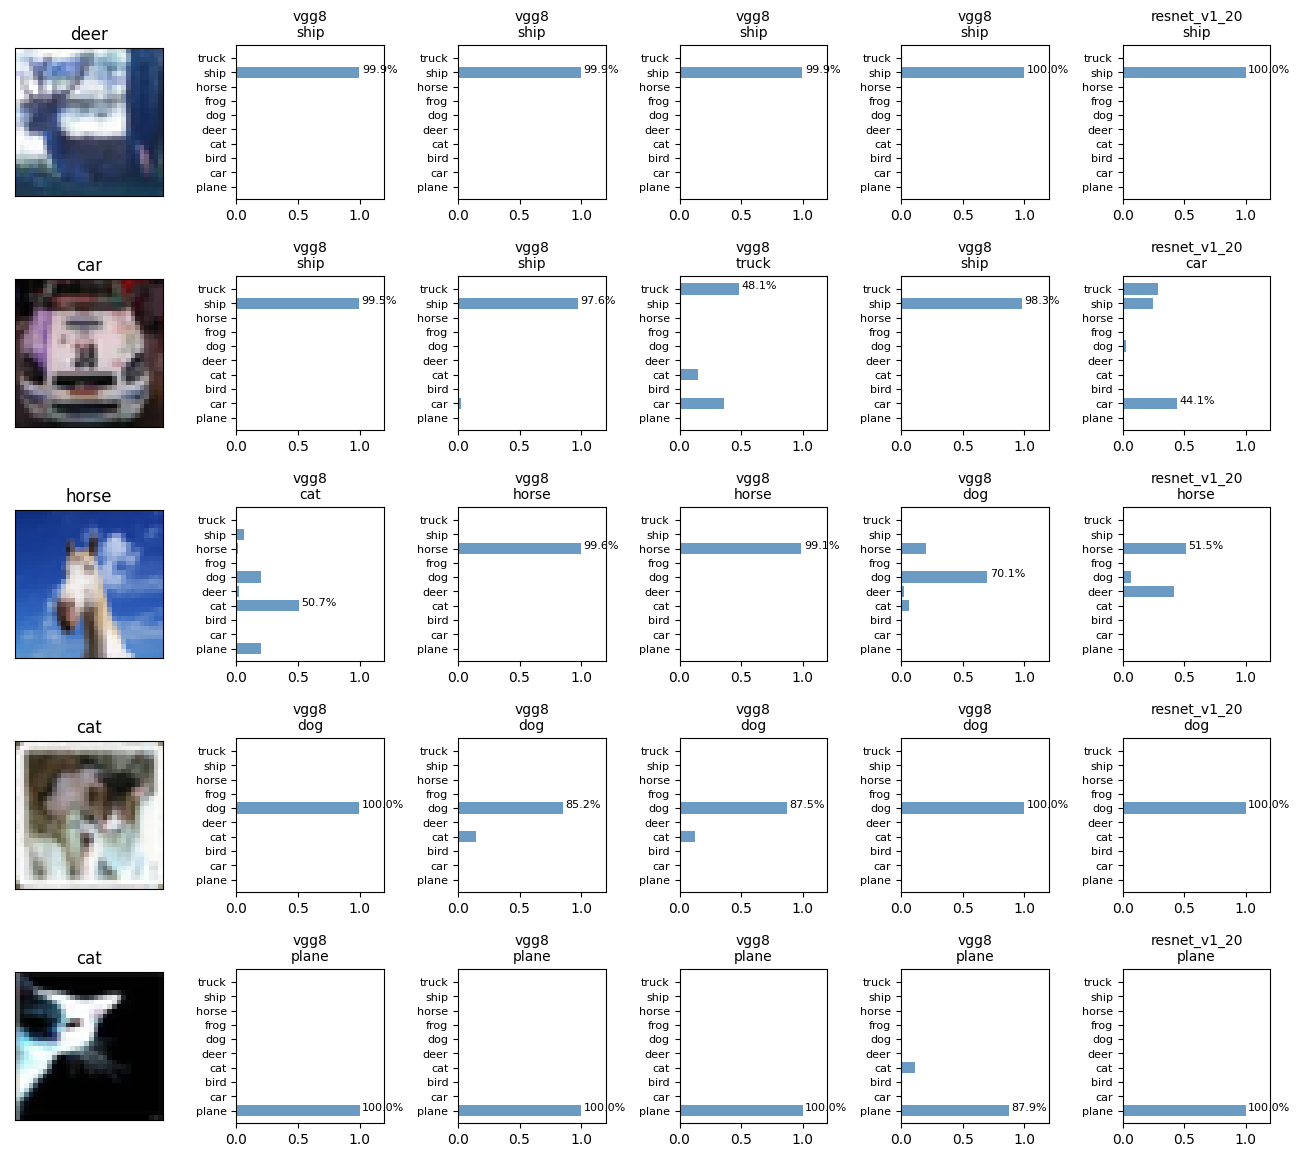

In [37]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [38]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.5896327495574951, 'accuracy': 0.8967999815940857, 'mae': 25.367116928100586}
313/313 [==============================] - 1s 4ms/step
(10000, 10)


In [39]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 1s 3ms/step


precision  recall        f1
plane   0.904245   0.916  0.910084
car     0.944334   0.950  0.947159
bird    0.872802   0.844  0.858160
cat     0.819549   0.763  0.790264
deer    0.889655   0.903  0.896278
dog     0.824832   0.857  0.840608
frog    0.897901   0.941  0.918945
horse   0.941358   0.915  0.927992
ship    0.943775   0.940  0.941884
truck   0.926950   0.939  0.932936

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9042    0.9160    0.9101      1000
         car     0.9443    0.9500    0.9472      1000
        bird     0.8728    0.8440    0.8582      1000
         cat     0.8195    0.7630    0.7903      1000
        deer     0.8897    0.9030    0.8963      1000
         dog     0.8248    0.8570    0.8406      1000
        frog     0.8979    0.9410    0.9189      1000
       horse     0.9414    0.9150    0.9280      1000
        ship     0.9438    0.9400    0.9419      1000
       truck     0.9269    0.9390    0.9329      1000

    accuracy                         0.8968     10000
   macro avg     0.8965    0.8968    0.8964     10000
weighted avg     0.8965    0.8968    0.8964     10000



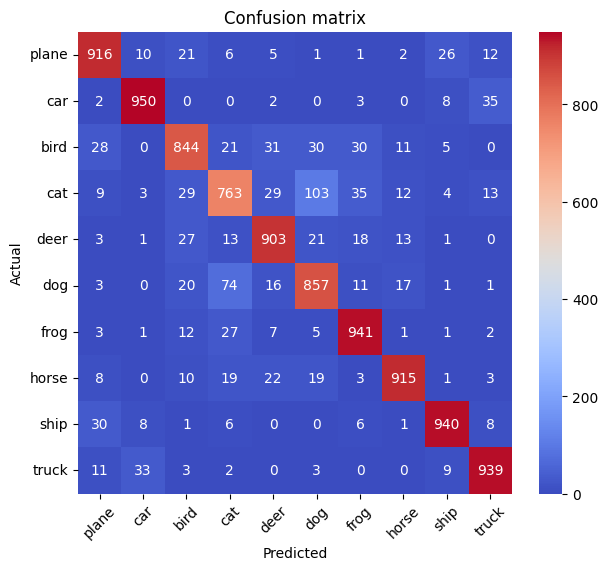

In [40]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [41]:
type(helper.datasets.train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset